# HR Data visualization, analysis, and prediction



Welcome!

This will be an extensive visualization, analysis, and prediction notebook. 

Here are some of my other notebooks:

**Gold price prediction using Prophet**

https://www.kaggle.com/joshuaswords/eda-gold-price-prediction-prophet


**Computer Vision with FastAI - Pneumonia prediction**

https://www.kaggle.com/joshuaswords/computer-vision-pneumonia-prediction-fastai


**Stroke Prediction with SMOTE and LIME explainer**

https://www.kaggle.com/joshuaswords/predicting-a-stroke-95-acc-with-lime-explainer


**2021 World Happiness Index EDA**

https://www.kaggle.com/joshuaswords/awesome-eda-2021-happiness-population


Let's get to it...



# Context

**Problem Statement**: Predict the probability of a candidate looking for a new job.

Essentially, I'll be attempting to predict **who is job-seeking and who is not.** 

**Note** - The main focus of this notebook is on **data visualization** so the predictive models can almost certainly be improved upon with some basic tweaks. 

Remember though, in industry it is difficult to deploy models that take hours to retrain daily. A good model is often better - and more practical - than a perfect one. Although this should be assessed on a case-by-case basis of course.



In [1]:

import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings("ignore")        
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.gridspec as grid_spec
import seaborn as sns
import squarify
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score


plt.rcParams["font.family"] = "serif"
plt.rcParams['figure.dpi'] = 200

/kaggle/input/hr-analytics-job-change-of-data-scientists/sample_submission.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_test.csv
/kaggle/input/hr-analytics-job-change-of-data-scientists/aug_train.csv


# Loading the data

In [2]:
aug_train = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv')
aug_test = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_test.csv')
aug_train.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0


# Dealing with missing values

As I have said in previous notebooks, dealing with missing values is often subjective. 

I like to keep categorical data where I can, as perhaps the fact that we do not have a company size or the company type could actually tell us something.

Additionally, I will keep the null gender values as of these, 30% have a target of 1 in the dataset, so this could be a telling data point, even if we don't quite understand it yet. 

As a reminder:
**Target: 0 – Not looking for job change, 1 – Looking for a job change**

In [3]:
# Check for nulls
aug_train.isna().sum()/len(aug_train)

enrollee_id               0.000000
city                      0.000000
city_development_index    0.000000
gender                    0.235306
relevent_experience       0.000000
enrolled_university       0.020148
education_level           0.024011
major_discipline          0.146832
experience                0.003393
company_size              0.309949
company_type              0.320493
last_new_job              0.022080
training_hours            0.000000
target                    0.000000
dtype: float64

In [4]:
# I like to keep categorical data where I can, as perhaps the fact that we do not have a company size or the company type
# could actually tell us something.


aug_train['last_new_job'] = aug_train['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
aug_train['enrolled_university'][aug_train['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
aug_train['company_size'] = aug_train['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

aug_train['experience'] = aug_train['experience'].apply(lambda x: '0' if x == '<1' else x)
aug_train['experience'] = aug_train['experience'].apply(lambda x: '20' if x == '>20' else x)


aug_train['company_size'].fillna('0',inplace=True)
aug_train['company_type'].fillna('Unknown',inplace=True)
aug_train['major_discipline'].fillna('Unknown',inplace=True)
aug_train['gender'].fillna('Not provided',inplace=True)


# Repeat steps on Test set

aug_test['last_new_job'] = aug_test['last_new_job'].apply(lambda x: 'Never' if x == 'never' else x) #just reads nicer
aug_test['enrolled_university'][aug_test['enrolled_university'] == 'no_enrollment'] = 'No Enrollment' #just reads nicer
aug_test['company_size'] = aug_test['company_size'].apply(lambda x: '10-49' if x == '10/49' else x) #diff replacement method

aug_test['experience'] = aug_test['experience'].apply(lambda x: '0' if x == '<1' else x)
aug_test['experience'] = aug_test['experience'].apply(lambda x: '20' if x == '>20' else x)

aug_test['company_size'].fillna('0',inplace=True)
aug_test['company_type'].fillna('Unknown',inplace=True)
aug_test['major_discipline'].fillna('Unknown',inplace=True)
aug_test['gender'].fillna('Not provided',inplace=True)



# This is what I mean with respect to the gender categories:

aug_train['target'].groupby(aug_train['gender']).mean()

gender
Female          0.263328
Male            0.227819
Not provided    0.308119
Other           0.261780
Name: target, dtype: float64

In [5]:
# I will drop the remaining missing data

aug_train.dropna(inplace=True)
aug_test.dropna(inplace=True)
aug_train.isna().sum()/len(aug_train)


enrollee_id               0.0
city                      0.0
city_development_index    0.0
gender                    0.0
relevent_experience       0.0
enrolled_university       0.0
education_level           0.0
major_discipline          0.0
experience                0.0
company_size              0.0
company_type              0.0
last_new_job              0.0
training_hours            0.0
target                    0.0
dtype: float64

In [6]:
# Converting objects to integers

aug_train['experience'] = aug_train['experience'].astype(str).astype(int)
aug_test['experience'] = aug_test['experience'].astype(str).astype(int)

aug_train['training_hours'] = aug_train['training_hours'].astype(str).astype(int)
aug_test['training_hours'] = aug_test['training_hours'].astype(str).astype(int)

I like to order my categorical variables. This gives much more control over your visuals and enables you to tell the story you're trying to tell

In [7]:
# Orders

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']
 
# for visuals
train_df = aug_train
test_df = aug_test



# Data Visualization 

**This will be an EXPLORATORY visualization, as opposed to EXPLANATORY.**


I will also make use of **GridSpec** as I want to practice this technique. 


Let's see if we can understand why people might look for a new job...


The colour palette I will use is below:

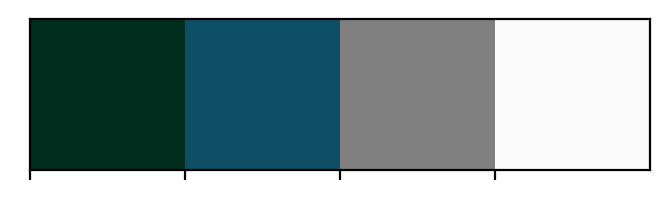

In [8]:
sns.palplot(['#002d1d','#0e4f66','gray','#fbfbfb'])

# How many job-seekers are there?

First of all, I want to see how many job-seekers there are in our training set. 

Do we have a balanced dateset? Or Imbalanced? The answer to these question may influence our models later on.

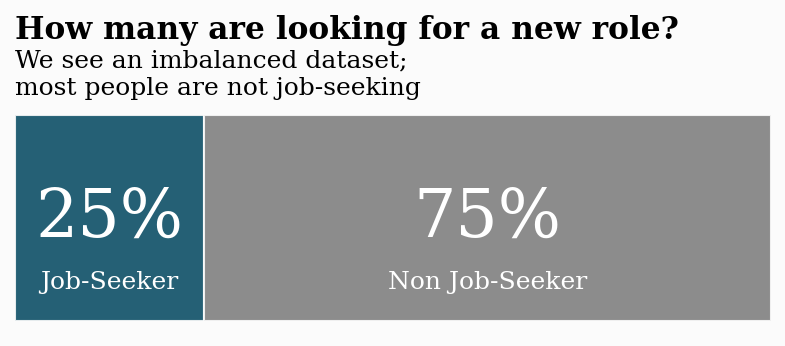

In [9]:
x=train_df.groupby(['target'])['target'].count()
y=len(train_df)
r=((x/y)).round(2)
ratio = pd.DataFrame(r).T


fig, ax = plt.subplots(1,1,figsize=(6.5, 2),dpi=150)
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color)
ax.set_facecolor(background_color) 

ax.barh(ratio.index, ratio[1.0], color='#0e4f66', alpha=0.9, ec=background_color, label='Job-Seeker')
ax.barh(ratio.index, ratio[0.0], left=ratio[1.0], color='gray', alpha=0.9,ec=background_color, label='Non Job-Seeker')

ax.set_xlim(0, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.legend().set_visible(False)
for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[1.0][i]*100)}%", xy=(ratio[1.0][i]/2, i),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Job-Seeker", xy=(ratio[1.0][i]/2, -0.25),va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',color='white')
    
    
for i in ratio.index:
    ax.annotate(f"{int(ratio[0.0][i]*100)}%", xy=(ratio[1.0][i]+ratio[0.0][i]/2, i),va = 'center', ha='center',fontsize=32, fontweight='light', fontfamily='serif',color='white')
    ax.annotate("Non Job-Seeker", xy=(ratio[1.0][i]+ratio[0.0][i]/2, -0.25),va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',color='white')


fig.text(0.125,1.1,'How many are looking for a new role?', fontfamily='serif',fontsize=15, fontweight='bold')
fig.text(0.125,0.915,'We see an imbalanced dataset;\nmost people are not job-seeking',fontfamily='serif',fontsize=12)  


plt.show()

We have an imbalanced dataset - that is,cmany **more non job-seekers than job-seekers**.

This is a problem that we can address later. For now, let's continue **exploring the data**

# How do the Train & Test set compare to each other?

Here I'll show an example of how you can use GridSpec.

GridSpec enables you to plot multiple plots and is highly customisable - a skill worth picking up!

This is really valuable because you can convey a lot of information in a small amount of space. 

I'll compare the Train & Test sets here...

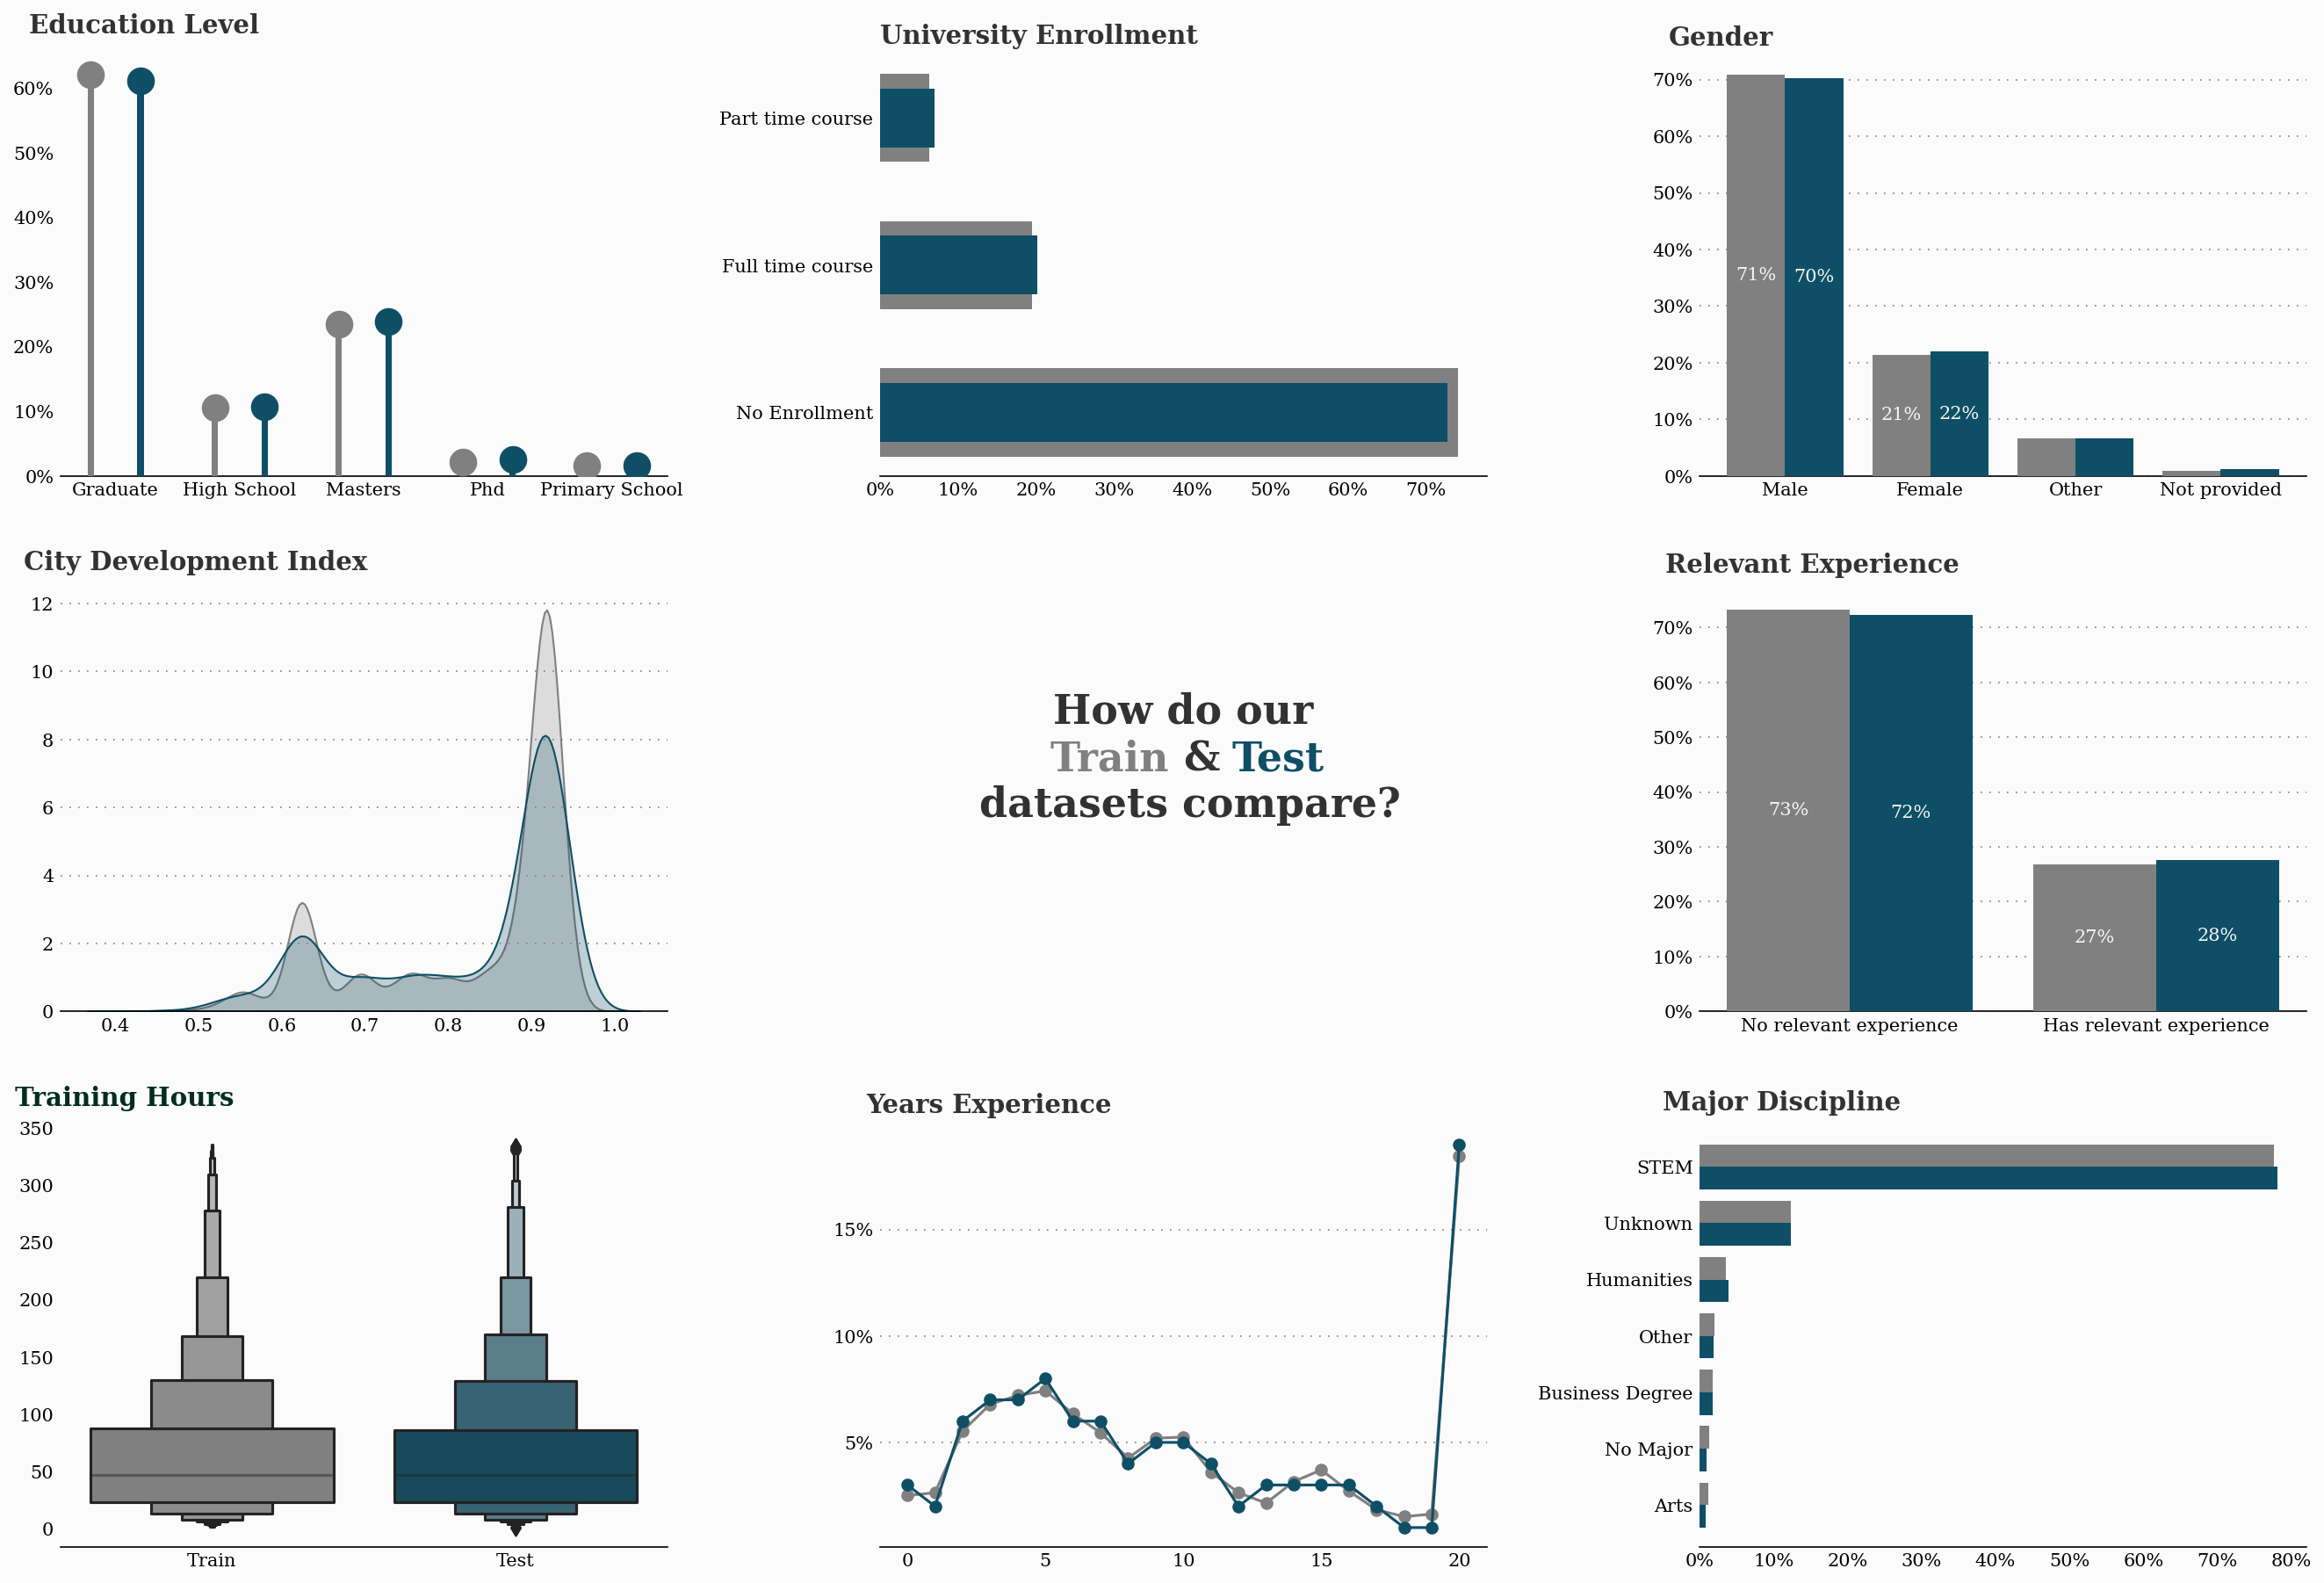

In [10]:
background_color = "#fbfbfb"

fig = plt.figure(figsize=(22,15),dpi=150)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.35, hspace=0.27)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
ax5 = fig.add_subplot(gs[1, 2])
ax6 = fig.add_subplot(gs[2, 0])
ax7 = fig.add_subplot(gs[2, 1])
ax8 = fig.add_subplot(gs[2, 2])


# Ax0 - EDUCATION LEVEL
train = pd.DataFrame(train_df["education_level"].value_counts())
train["Percentage"] = train["education_level"].apply(lambda x: x/sum(train["education_level"])*100)
train = train.sort_index()

test = pd.DataFrame(test_df["education_level"].value_counts())
test["Percentage"] = test["education_level"].apply(lambda x: x/sum(test["education_level"])*100)
test = test.sort_index()

ax0.bar(np.arange(len(train.index)), height=train["Percentage"], zorder=3, color="gray", width=0.05)
ax0.scatter(np.arange(len(train.index)), train["Percentage"], zorder=3,s=200, color="gray")
ax0.bar(np.arange(len(test.index))+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.05)
ax0.scatter(np.arange(len(test.index))+0.4, test["Percentage"], zorder=3,s=200, color="#0e4f66")
ax0.text(-0.5, 68.5, 'Education Level', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax0.yaxis.set_major_formatter(mtick.PercentFormatter())
ax0.yaxis.set_major_locator(mtick.MultipleLocator(10))
ax0.set_xticks(np.arange(len(train.index))+0.4 / 2)
ax0.set_xticklabels(list(train.index),rotation=0)


# Ax1 - ENROLLED IN UNIVESITY
train = pd.DataFrame(train_df["enrolled_university"].value_counts())
train["Percentage"] = train["enrolled_university"].apply(lambda x: x/sum(train["enrolled_university"])*100).loc[enroll_order]
test = pd.DataFrame(test_df["enrolled_university"].value_counts())
test["Percentage"] = test["enrolled_university"].apply(lambda x: x/sum(test["enrolled_university"])*100).loc[enroll_order]

ax1.text(0, 2.5, 'University Enrollment', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax1.barh(train.index, train['Percentage'], color="gray", zorder=3, height=0.6)
ax1.barh(test.index, test['Percentage'], color="#0e4f66", zorder=3, height=0.4)
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_locator(mtick.MultipleLocator(10))

###
# Ax2 - GENDER 
train = pd.DataFrame(train_df["gender"].value_counts())
train["Percentage"] = train["gender"].apply(lambda x: x/sum(train["gender"])*100)
test = pd.DataFrame(test_df["gender"].value_counts())
test["Percentage"] = test["gender"].apply(lambda x: x/sum(test["gender"])*100)

x = np.arange(len(train))
ax2.text(-0.6, 76, 'Gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax2.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax2.bar(x, height=train["Percentage"], zorder=3, color="gray", width=0.4)
ax2.bar(x+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax2.set_xticks(x + 0.4 / 2)
ax2.set_xticklabels(['Male','Female','Other','Not provided'])
ax2.yaxis.set_major_formatter(mtick.PercentFormatter())
ax2.yaxis.set_major_locator(mtick.MultipleLocator(10))
for i,j in zip([0, 1], train["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1], test["Percentage"]):
    ax2.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
    

    
## Ax 3 - CDI

ax3.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
train = pd.DataFrame(train_df["city_development_index"])
test = pd.DataFrame(test_df["city_development_index"])
sns.kdeplot(train["city_development_index"], ax=ax3,color="gray", shade=True, label="Train")
sns.kdeplot(test["city_development_index"], ax=ax3, color="#0e4f66", shade=True, label="Test")
ax3.text(0.29, 13, 'City Development Index', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax3.yaxis.set_major_locator(mtick.MultipleLocator(2))
ax3.set_ylabel('')    
ax3.set_xlabel('')

## AX4 - TITLE

ax4.spines["bottom"].set_visible(False)
ax4.tick_params(left=False, bottom=False)
ax4.set_xticklabels([])
ax4.set_yticklabels([])
ax4.text(0.5, 0.6, 'How do our\n\n datasets compare?', horizontalalignment='center', verticalalignment='center',fontsize=22, fontweight='bold', fontfamily='serif', color="#323232")
ax4.text(0.28,0.57,"Train", fontweight="bold", fontfamily='serif', fontsize=22, color='gray')
ax4.text(0.5,0.57,"&", fontweight="bold", fontfamily='serif', fontsize=22, color='#323232')
ax4.text(0.58,0.57,"Test", fontweight="bold", fontfamily='serif', fontsize=22, color='#0e4f66')




### Ax5 - RELEVANT EXPERIENCE
train = pd.DataFrame(train_df["relevent_experience"].value_counts())
train["Percentage"] = train["relevent_experience"].apply(lambda x: x/sum(train["relevent_experience"])*100)
test = pd.DataFrame(test_df["relevent_experience"].value_counts())
test["Percentage"] = test["relevent_experience"].apply(lambda x: x/sum(test["relevent_experience"])*100)
x = np.arange(len(train))
ax5.text(-0.4, 80, 'Relevant Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax5.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax5.bar(x, height=train["Percentage"], zorder=3, color="gray", width=0.4)
ax5.bar(x+0.4, height=test["Percentage"], zorder=3, color="#0e4f66", width=0.4)
ax5.set_xticks(x + 0.4 / 2)
ax5.set_xticklabels(['No relevant experience','Has relevant experience'])
ax5.yaxis.set_major_formatter(mtick.PercentFormatter())
ax5.yaxis.set_major_locator(mtick.MultipleLocator(10))

for i,j in zip([0, 1, 2], train["Percentage"]):
    ax5.annotate(f'{j:0.0f}%',xy=(i, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')
for i,j in zip([0, 1, 2], test["Percentage"]):
    ax5.annotate(f'{j:0.0f}%',xy=(i+0.4, j/2), color='#f6f6f6', horizontalalignment='center', verticalalignment='center')

    
    
# Ax6 - TRAINING HOURS
train = pd.DataFrame(train_df["training_hours"])
train["TrainTest"] = "Train"
test = pd.DataFrame(test_df["training_hours"])
test["TrainTest"] = "Test"
ax6.text(-0.65, 370, 'Training Hours', fontsize=14, fontweight='bold', fontfamily='serif', color="#002d1d")
comb_graph_temp_df = pd.concat([train, test], axis=0)
sns.boxenplot(ax=ax6, y="training_hours", x="TrainTest", data=comb_graph_temp_df, palette=["gray", "#0e4f66"])
ax6.set_xlabel("")
ax6.set_ylabel("")


# Ax7 - EXPERIENCE YRS
train = pd.DataFrame(train_df["experience"].value_counts())
train["Percentage"] = train["experience"].apply(lambda x: x/sum(train["experience"])*100)
train = train.sort_index()
test = pd.DataFrame(test_df["experience"].value_counts())
test["Percentage"] = round(test["experience"].apply(lambda x: x/sum(test["experience"])*100),).astype(int)
test = test.sort_index()
ax7.grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))
ax7.plot(train.index, train["Percentage"], zorder=3, color="gray", marker='o')
ax7.plot(test.index, test["Percentage"], zorder=3, color="#0e4f66", marker='o')
ax7.text(-1.5, 20.5, 'Years Experience', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax7.set_yticklabels(labels = ['0   ', '5%','10%','15%'])
ax7.xaxis.set_major_locator(mtick.MultipleLocator(5))
ax7.yaxis.set_major_locator(mtick.MultipleLocator(5))


# Ax8 - MAJOR DISCIPLINE
train = pd.DataFrame(train_df["major_discipline"].value_counts())
train["Percentage"] = train["major_discipline"].apply(lambda x: x/sum(train["major_discipline"])*100)
test = pd.DataFrame(test_df["major_discipline"].value_counts())
test["Percentage"] = test["major_discipline"].apply(lambda x: x/sum(test["major_discipline"])*100)

ax8.barh(np.arange(len(train.index)), train["Percentage"], zorder=3, color="gray", height=0.4)
ax8.barh(np.arange(len(test.index))+0.4, test["Percentage"], zorder=3, color="#0e4f66", height=0.4)
ax8.text(-5, -0.8, 'Major Discipline', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
ax8.xaxis.set_major_formatter(mtick.PercentFormatter())
ax8.yaxis.set_major_locator(mtick.MultipleLocator(1))
ax8.set_yticks(np.arange(len(test.index))+0.4 / 2)
ax8.set_yticklabels(list(test.index))
ax8.invert_yaxis()



for i in range(0,9):
    locals()["ax"+str(i)].set_facecolor(background_color) 
    
for i in range(0,9):
    locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)


for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)

plt.show()

# The Train & Tests sets are similar - that's good news

If the training set has wildy different characteristics to our test set then we really are in for a difficult time.

We'd need to ask if the training population can really help us predict the target. 

In this case though, we're fine. 

# Now let's focus on the Training set and explore the data...

You'll note that I often incoroprate text in to my visuals. I'll often an annotations to the plots themselves, for example at the 'mean', or at peaks in the data etc. 

In this case, I've included an explanation of what we're seeing and what it might mean. This helps your audience to understand your data, but it also helps them to get thinking in a way that is in line with the story you are trying to craft.

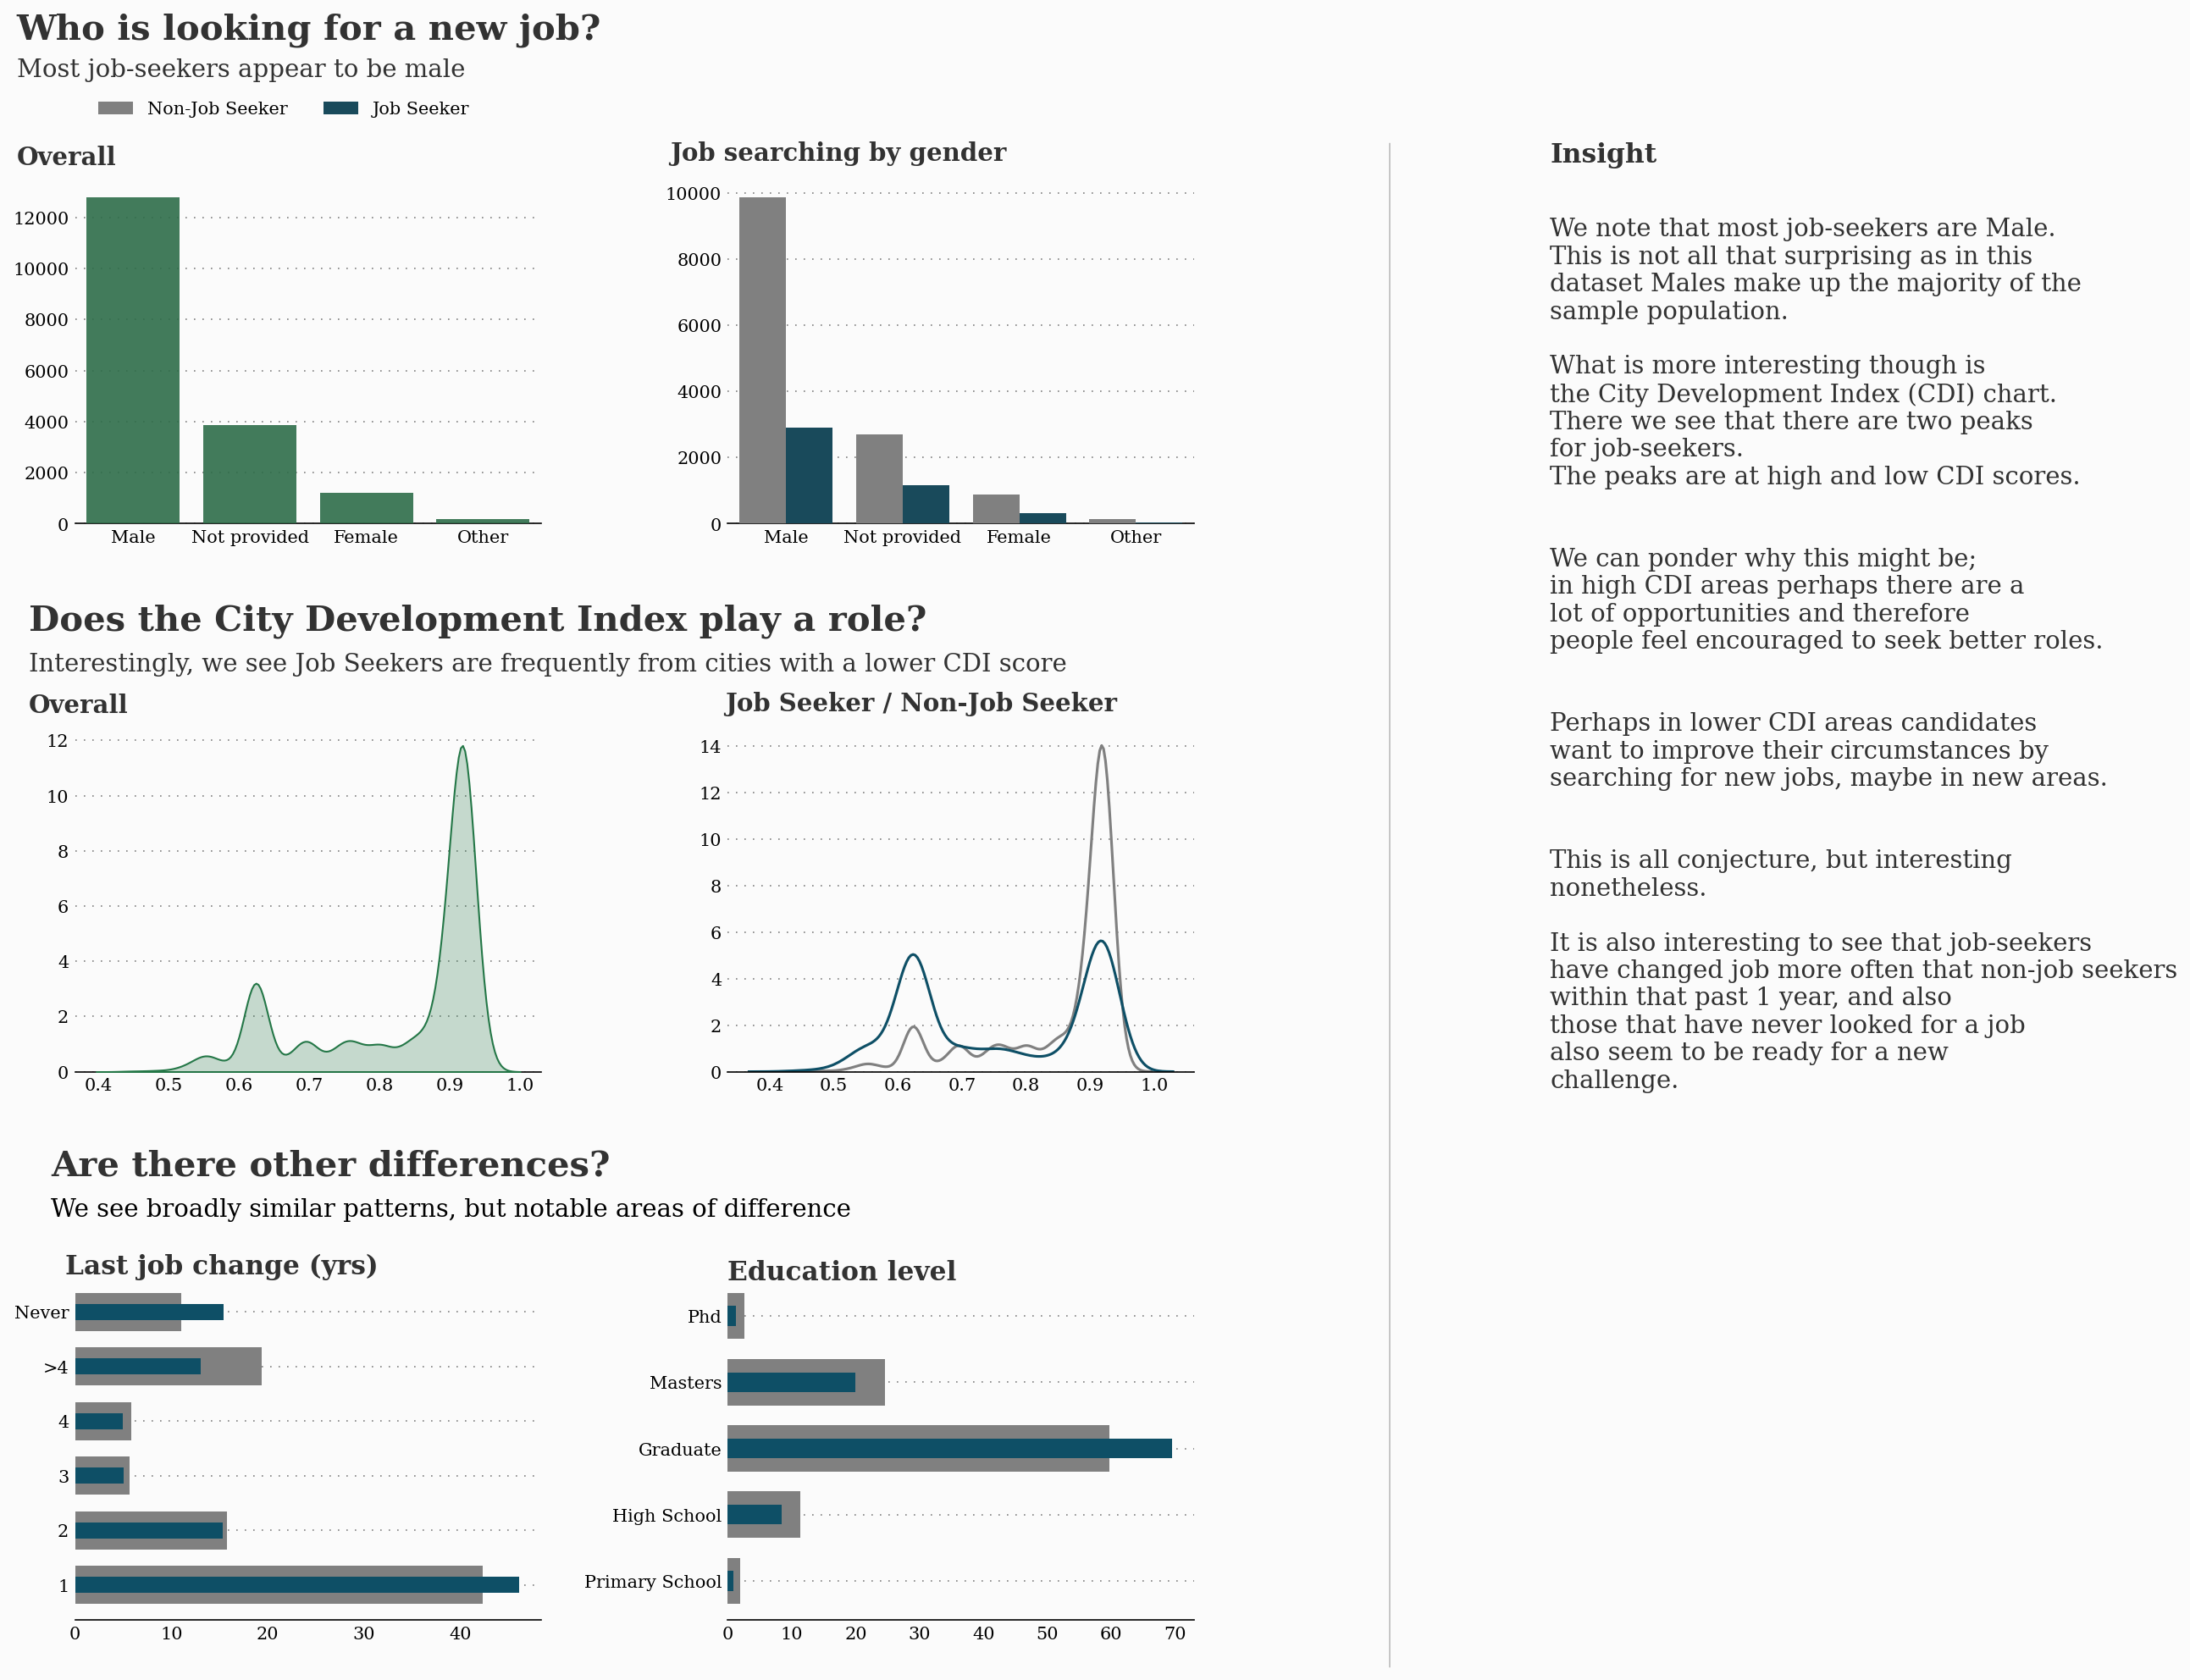

In [11]:
color_palette=["gray","#0e4f66"]
fig = plt.figure(figsize=(18,15), dpi=150)
fig.patch.set_facecolor(background_color) # figure background color
gs = fig.add_gridspec(3, 3)
gs.update(wspace=0.4, hspace=0.6)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
ax4 = fig.add_subplot(gs[2, 0])
ax5 = fig.add_subplot(gs[2, 1])

# Distribution
ax0.text(-1, 19000, 'Who is looking for a new job?', fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")
ax0.text(-1, 17500, 'Most job-seekers appear to be male', fontsize=14, fontweight='light', fontfamily='serif', color="#323232")
ax0.text(-1, 14050, 'Overall', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.countplot(x=train_df["gender"], color="#247747", ax=ax0, zorder=3,alpha=0.9)



# Gender
ax1.text(-1, 11000, 'Job searching by gender', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.countplot(x="gender", hue="target", data=train_df, palette=color_palette, ax=ax1, zorder=3)
legend_labels, _= ax1.get_legend_handles_labels()
ax1.legend(legend_labels, ["Non-Job Seeker", "Job Seeker"], ncol=2, bbox_to_anchor=(-0.52, 1.28), facecolor=background_color, edgecolor=background_color)



# CDI
ax2.text(0.3, 16, 'Does the City Development Index play a role?', fontsize=20, fontweight='bold', fontfamily='serif', color="#323232")
ax2.text(0.3, 14.5, 'Interestingly, we see Job Seekers are frequently from cities with a lower CDI score', fontsize=14, fontweight='light', fontfamily='serif', color="#323232")
ax2.text(0.3, 13, 'Overall', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.kdeplot(train_df["city_development_index"], color="#247747", shade=True, ax=ax2, zorder=3)



ax3.text(0.33, 15.5, 'Job Seeker / Non-Job Seeker', fontsize=14, fontweight='bold', fontfamily='serif', color="#323232")
sns.kdeplot(train_df.loc[(train_df["target"]==0), "city_development_index"], color="gray", label="Not Survived", ax=ax3)
sns.kdeplot(train_df.loc[(train_df["target"]==1), "city_development_index"], color="#0e4f66", label="Survived", ax=ax3)



###
aug_train['count'] = 1
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

job_change = aug_train.groupby(['education_level','last_new_job'])['experience'].sum().unstack().loc[ed_order,job_order]

job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack()
notseek_job_change = no_job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T
seek_job_change = job_hunt_only.groupby(['target','last_new_job'])['count'].sum().unstack().T

notseek_job_change.columns = ['count']
seek_job_change.columns = ['count']

notseek_job_change["percentage"] = notseek_job_change["count"].apply(lambda x: x/sum(notseek_job_change["count"])) *100
seek_job_change["percentage"] = seek_job_change["count"].apply(lambda x: x/sum(seek_job_change["count"])) *100


ed_notseek_job_change = no_job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T.loc[ed_order]
ed_seek_job_change = job_hunt_only.groupby(['target','education_level'])['count'].sum().unstack().T.loc[ed_order]

ed_notseek_job_change.columns = ['count']
ed_seek_job_change.columns = ['count']

ed_notseek_job_change["percentage"] = ed_notseek_job_change["count"].apply(lambda x: x/sum(ed_notseek_job_change["count"])) *100
ed_seek_job_change["percentage"] = ed_seek_job_change["count"].apply(lambda x: x/sum(ed_seek_job_change["count"])) *100

###


ax4.barh(notseek_job_change.index, notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax4.barh(seek_job_change.index, seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
ax4.xaxis.set_major_locator(mtick.MultipleLocator(10))


##
ax5.barh(ed_notseek_job_change.index, ed_notseek_job_change['percentage'], color="gray", zorder=3, height=0.7)
ax5.barh(ed_seek_job_change.index, ed_seek_job_change['percentage'], color="#0e4f66", zorder=3, height=0.3)
ax5.xaxis.set_major_locator(mtick.MultipleLocator(10))

##
ax4.text(-1, 5.7, 'Last job change (yrs)',fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')
ax5.text(0, 4.55, 'Education level', fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')

ax4.text(-2.5, 7.5, 'Are there other differences?', 
         fontsize=20, fontweight='bold', fontfamily='serif',color='#323232')

ax4.text(-2.5, 6.75, 
         'We see broadly similar patterns, but notable areas of difference', 
         fontsize=14, fontweight='light', fontfamily='serif')


####

fig.text(0.77, 0.89
         , 'Insight', fontsize=15, fontweight='bold', fontfamily='serif',color='#323232')

fig.text(0.77, 0.39, '''
We note that most job-seekers are Male.
This is not all that surprising as in this
dataset Males make up the majority of the
sample population.

What is more interesting though is
the City Development Index (CDI) chart.
There we see that there are two peaks
for job-seekers. 
The peaks are at high and low CDI scores. 


We can ponder why this might be;
in high CDI areas perhaps there are a 
lot of opportunities and therefore
people feel encouraged to seek better roles.


Perhaps in lower CDI areas candidates
want to improve their circumstances by
searching for new jobs, maybe in new areas. 


This is all conjecture, but interesting
nonetheless.

It is also interesting to see that job-seekers
have changed job more often that non-job seekers
within that past 1 year, and also
those that have never looked for a job
also seem to be ready for a new
challenge.
'''
         , fontsize=14, fontweight='light', fontfamily='serif',color='#323232')



import matplotlib.lines as lines
l1 = lines.Line2D([0.7, 0.7], [0.1, 0.9], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

for s in ["top","right","left"]:
    for i in range(0,6):
        locals()["ax"+str(i)].spines[s].set_visible(False)
        
for i in range(0,6):
        locals()["ax"+str(i)].set_facecolor(background_color)
        locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)
        locals()["ax"+str(i)].grid(color='gray', linestyle=':', axis='y', zorder=0,  dashes=(1,5))      

        
for x in range(0,4):
    for y in range(0,4):
        locals()["ax"+str(x)].set_xlabel("")
        locals()["ax"+str(y)].set_ylabel("")

plt.show()

# Let's now explore other factors like company size & employee experience...

Do more experienced employees seek new challenges?

Do employees at larger companies feel less valued?

Do employees at smaller companies crave new opportunities?

Both seem plausible. These are the questions that a good EDA can answer!


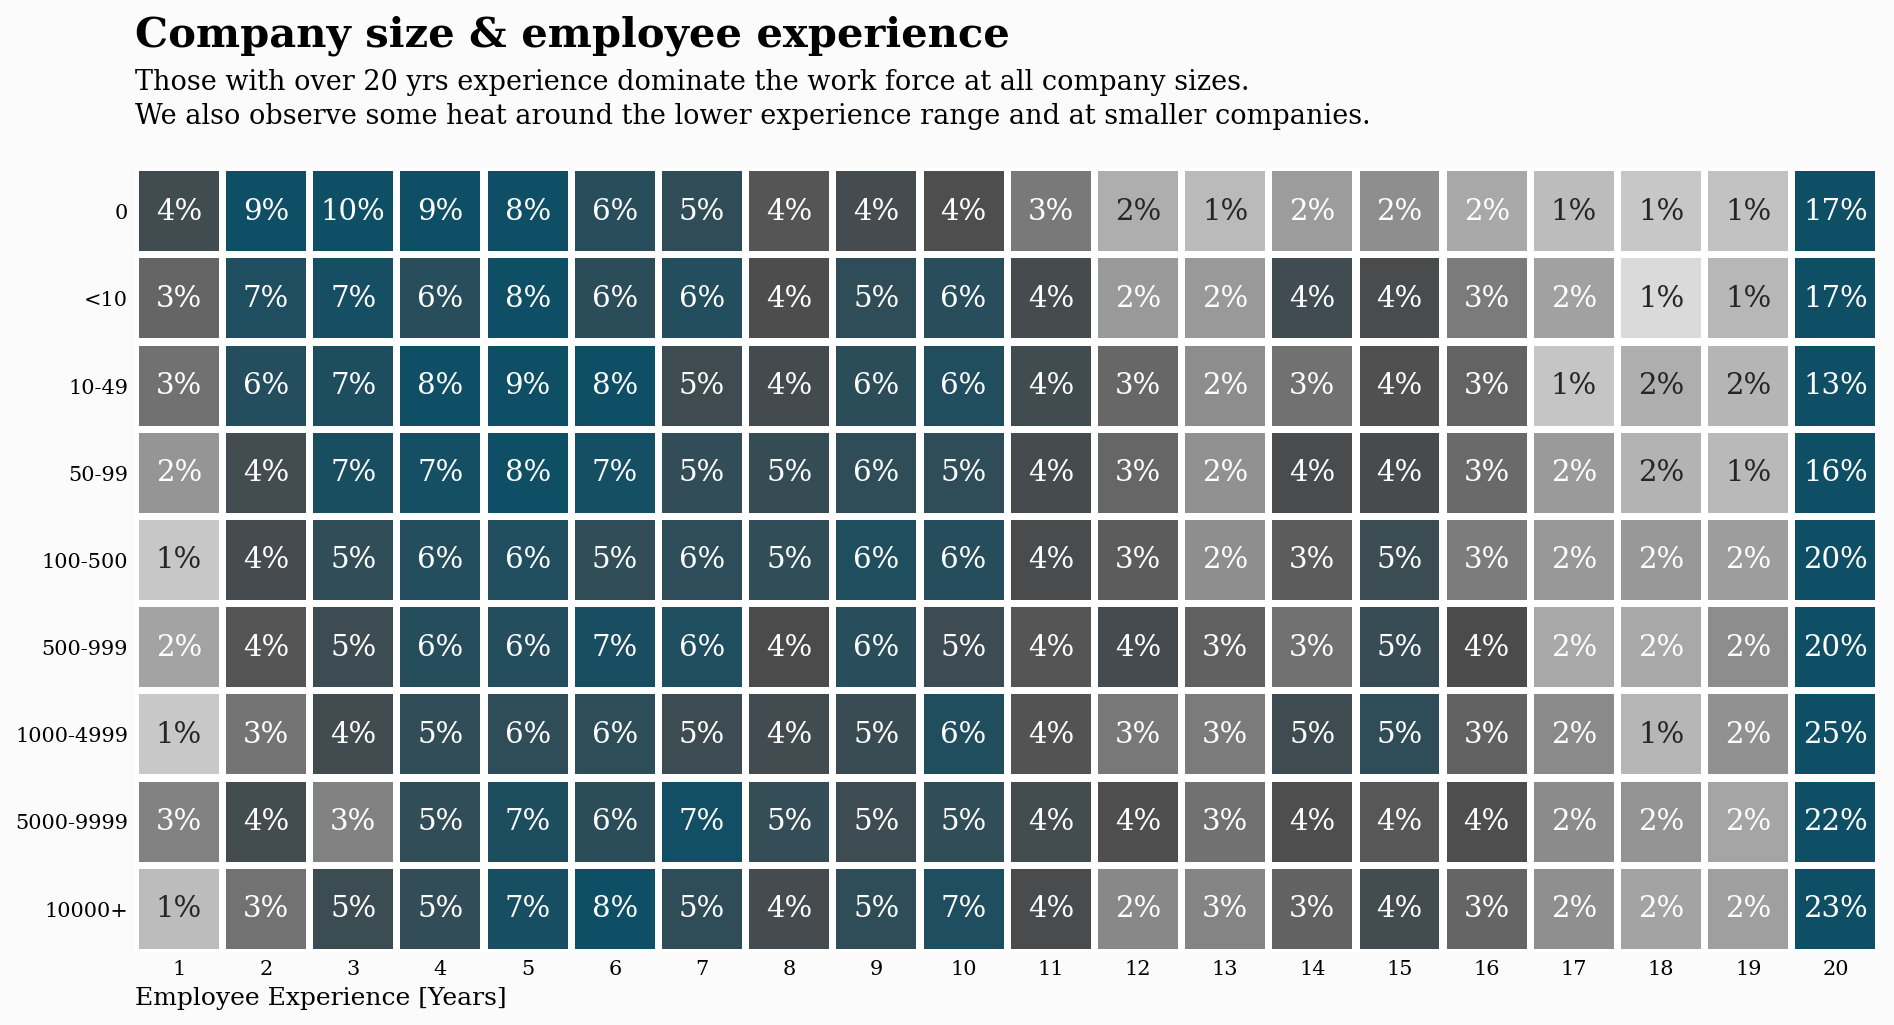

In [12]:
pv_gen_size = pd.pivot_table(aug_train, values='count',index=['gender'],columns=['company_size'],aggfunc=np.sum).loc[gender_order, size_order]
ct_gen_size = pd.crosstab(aug_train['company_size'],aug_train['experience'], normalize='index').loc[size_order,exp_yrs_order_2]


fig = plt.figure(figsize=(15,10), dpi=150) 
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(2, 1)
gs.update(wspace=0, hspace=-0.09)
ax0 = fig.add_subplot(gs[:,:])

colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=ct_gen_size, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})

 
ax0.set_facecolor(background_color) 
ax0.set_xlabel("Employee Experience [Years]",fontfamily='serif',fontsize=12,loc='left')
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

    
ax0.text(0, -1.4, 
         'Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.9, 
         'Those with over 20 yrs experience dominate the work force at all company sizes.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
ax0.text(0, -0.5, 
         'We also observe some heat around the lower experience range and at smaller companies.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )

ax0.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

It appears the as employee experience increases, they tend to work for larger companies.

Why might this be? Perhaps larger companies pay better, or perhaps more job security.

# Employee Experience & Company Size

Is there a noticeable difference between job-seekers and non-job-seekers?

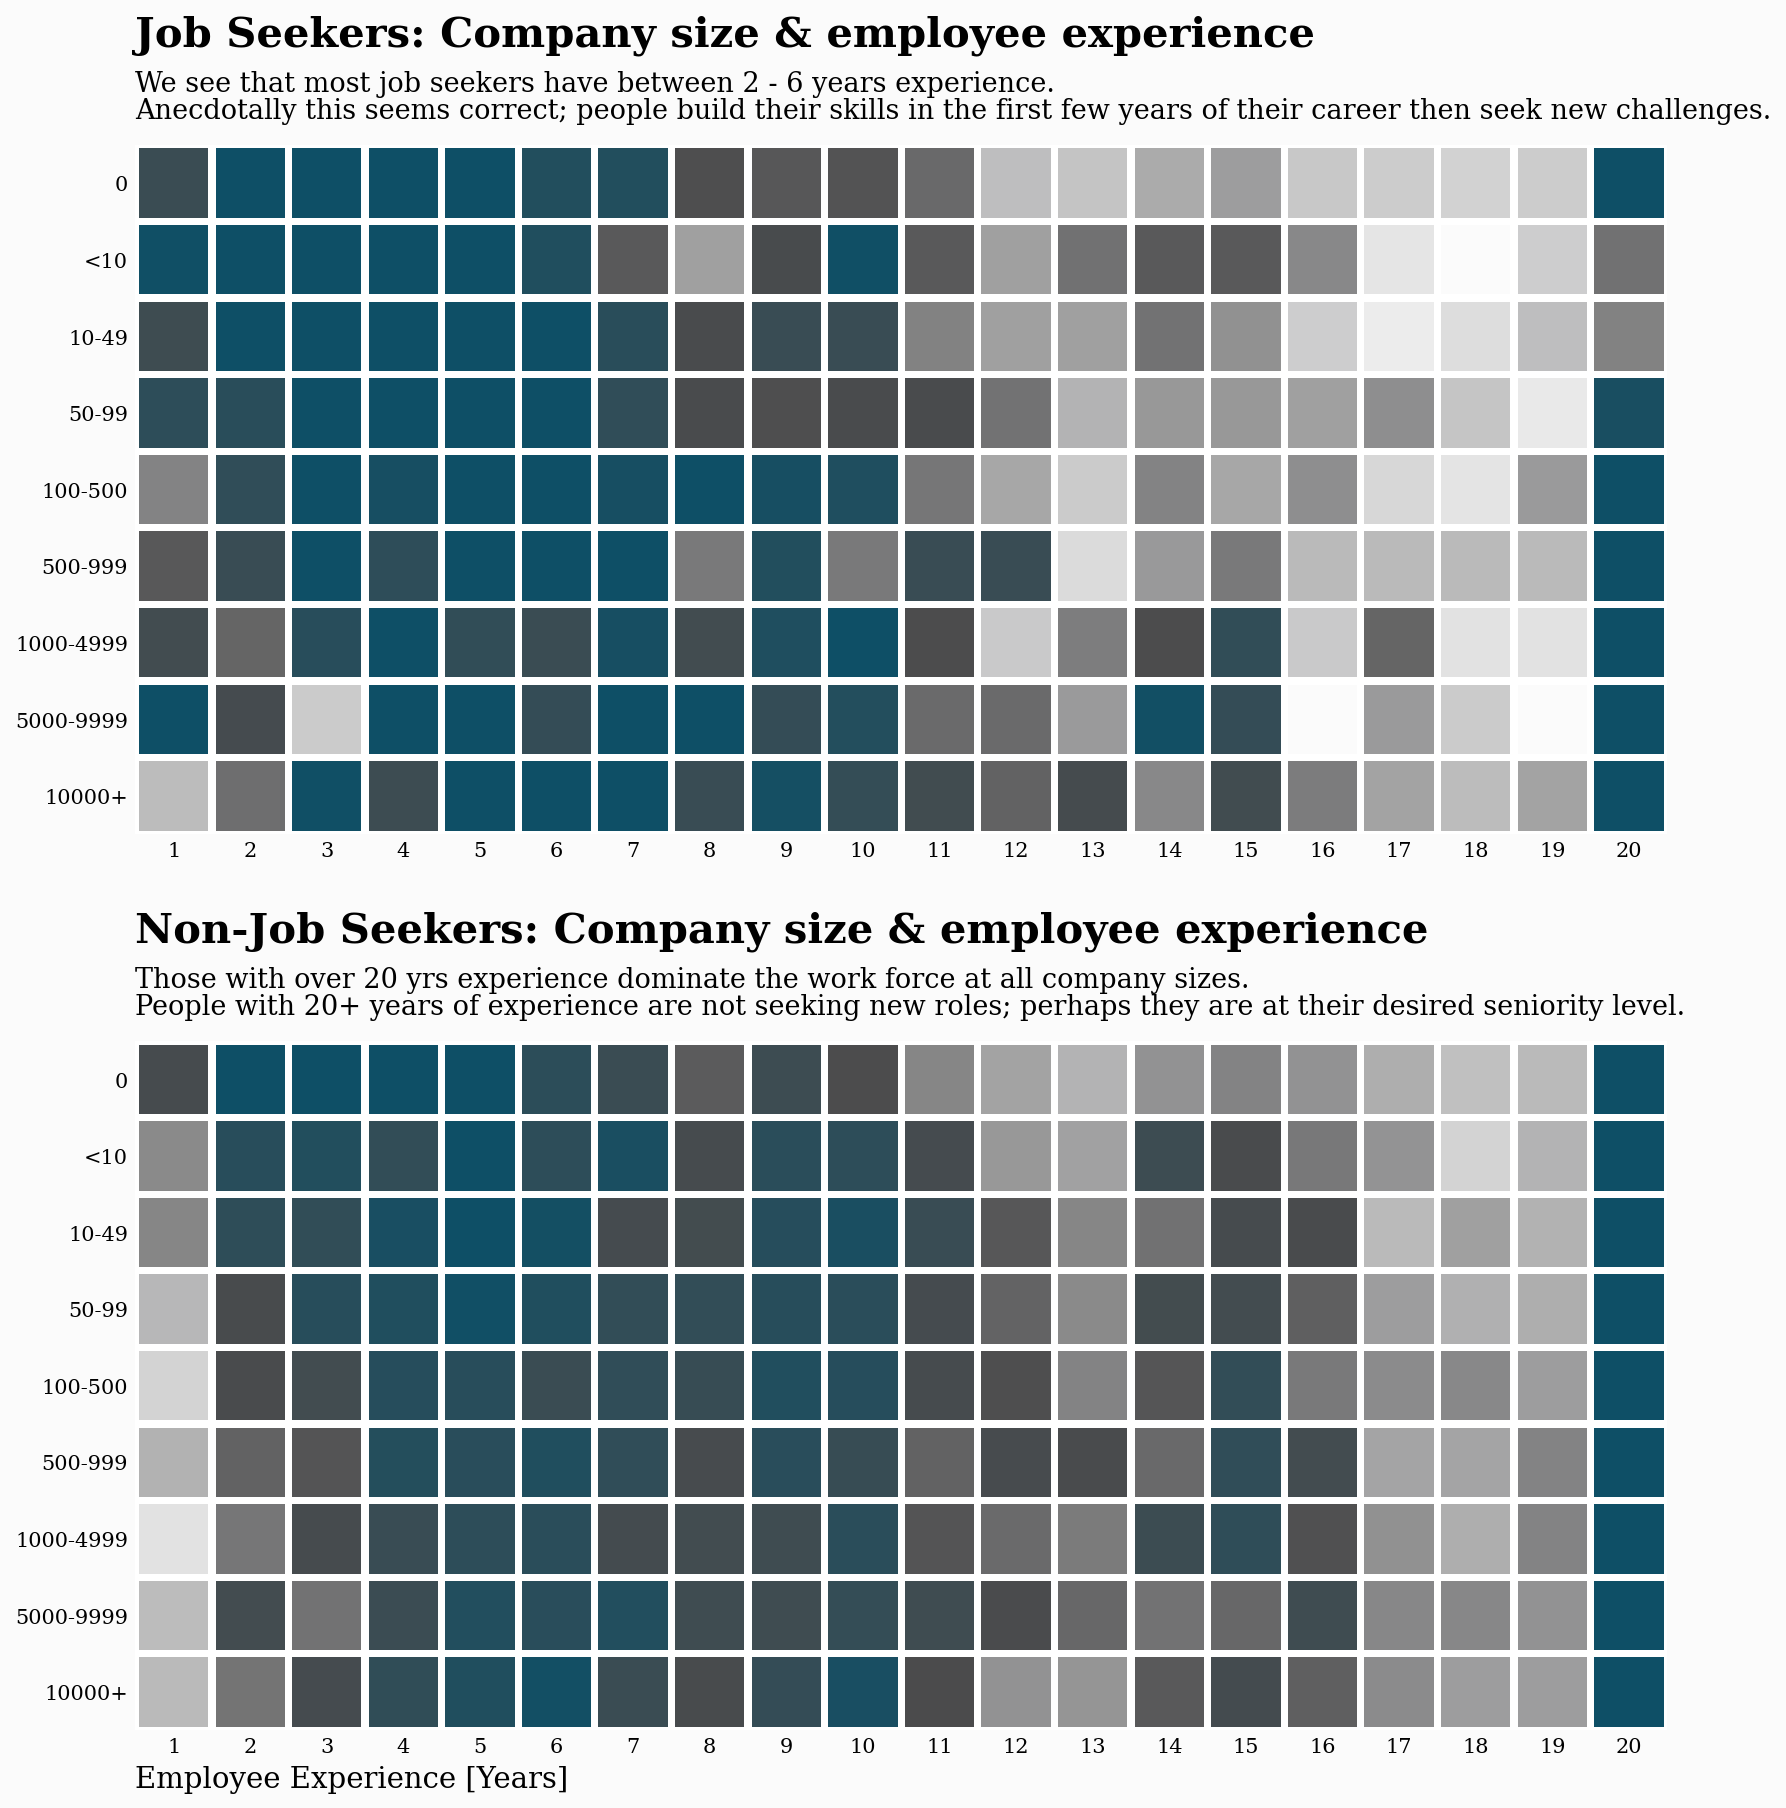

In [13]:
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

job_seek = pd.crosstab(job_hunt_only['company_size'],job_hunt_only['experience'], normalize='index').loc[size_order,exp_yrs_order_2]
no_seek = pd.crosstab(no_job_hunt_only['company_size'],no_job_hunt_only['experience'], normalize='index').loc[size_order,exp_yrs_order_2]

###
fig = plt.figure(figsize=(14,14),dpi=150)
fig.patch.set_facecolor(background_color)
gs = fig.add_gridspec(2, 3)
gs.update(wspace=0.2, hspace=0.3)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])


colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=job_seek, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=False, fmt='1.0%',annot_kws={"fontsize":14})

sns.heatmap(ax=ax1, data=no_seek, linewidths=.1, vmin=0, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=False, fmt='1.0%',annot_kws={"fontsize":14})

ax0.set_facecolor(background_color) 
ax0.set_xlabel("")
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)

    
ax0.set_xlabel("")
ax0.set_ylabel("")
ax1.set_xlabel("Employee Experience [Years]",fontfamily='serif',fontsize=14,loc='left')
ax1.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)

    
ax0.text(0, -1.3, 
         'Job Seekers: Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax1.text(0, -0.7, 
         'Those with over 20 yrs experience dominate the work force at all company sizes.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
ax1.text(0, -0.35, 
         'People with 20+ years of experience are not seeking new roles; perhaps they are at their desired seniority level.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
    
ax1.text(0, -1.3, 
         'Non-Job Seekers: Company size & employee experience', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.7, 
         'We see that most job seekers have between 2 - 6 years experience.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
ax0.text(0, -0.35, 
         'Anecdotally this seems correct; people build their skills in the first few years of their career then seek new challenges.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

# Education

We've explored some interesting feautures of our data, including employee experience and company size. 

Let's throw education in to the mix. 

Do job-seekers have a higher education level? Are they less educated? Or is there no difference at all?

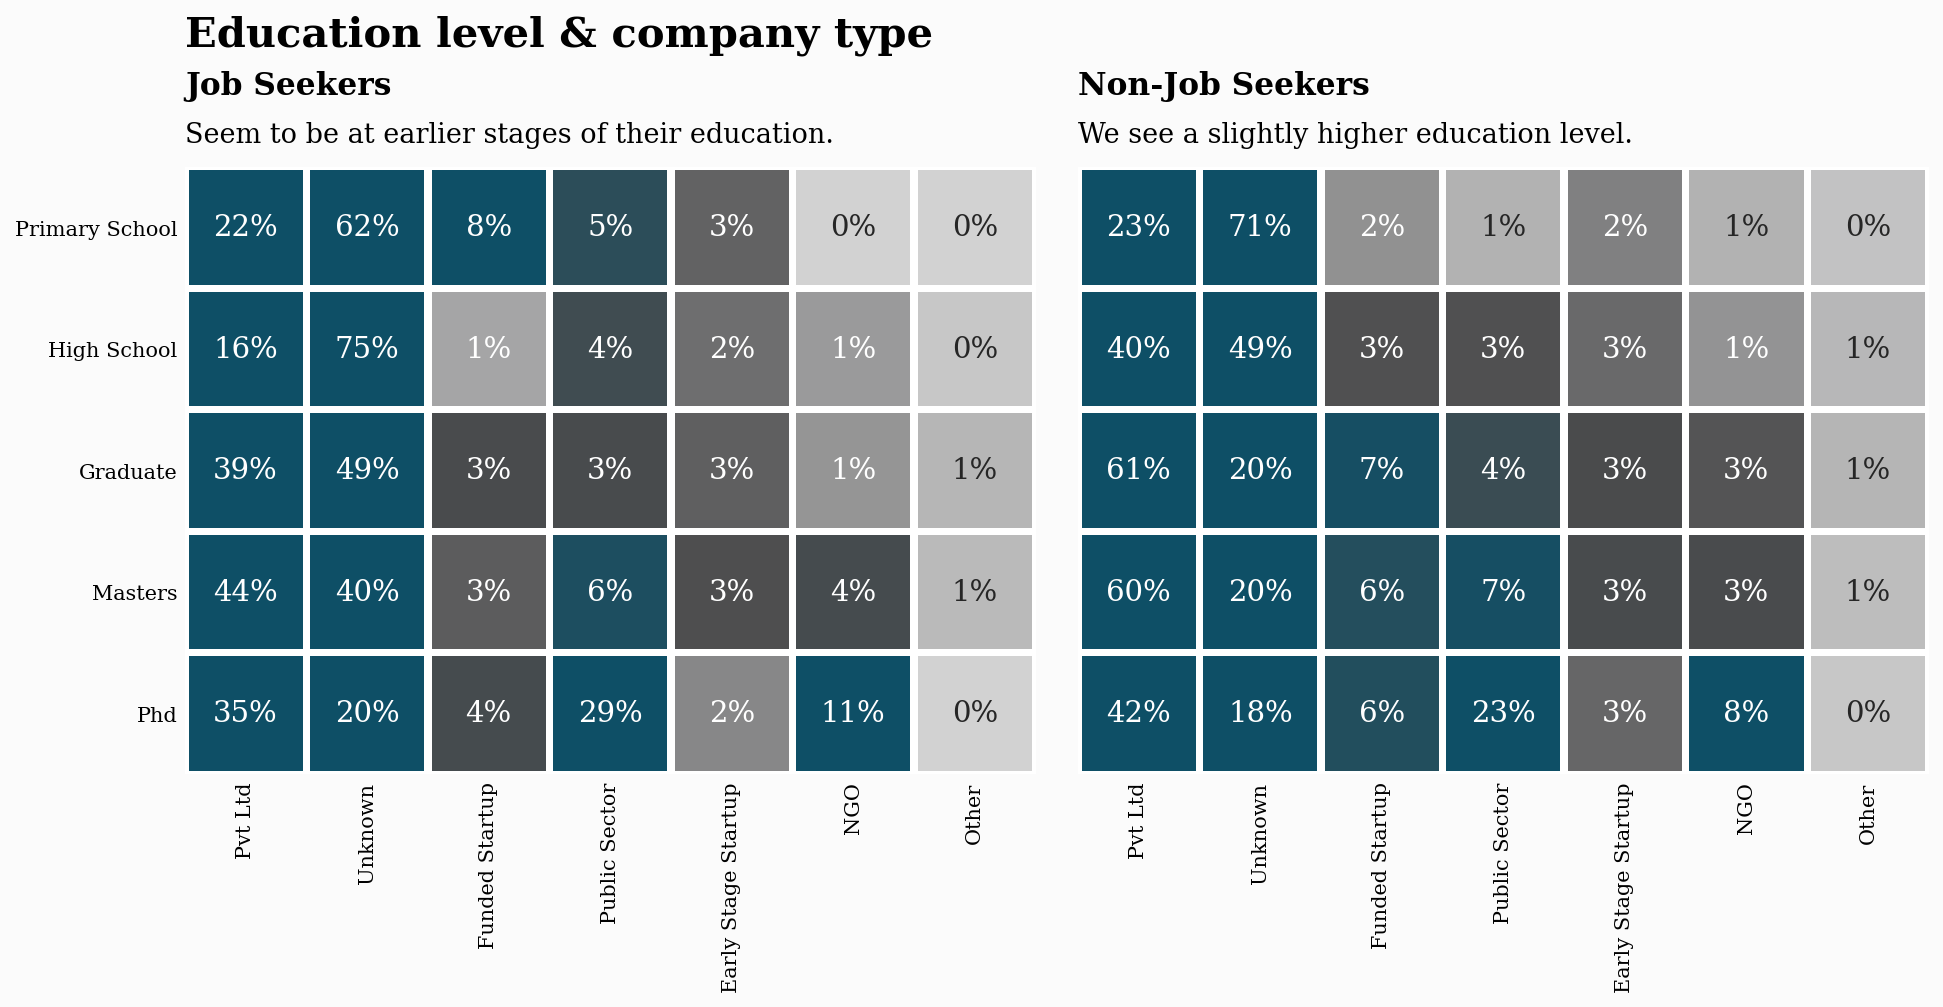

In [14]:
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]

job_seek = pd.crosstab(job_hunt_only['education_level'],job_hunt_only['company_type'], normalize='index').loc[ed_order,company_order]
no_seek = pd.crosstab(no_job_hunt_only['education_level'],no_job_hunt_only['company_type'], normalize='index').loc[ed_order,company_order]


fig = plt.figure(figsize=(15,15),dpi=150)
fig.patch.set_facecolor(background_color)

gs = fig.add_gridspec(1, 2)
gs.update(wspace=0.05, hspace=0.3)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])


colors = ["#fbfbfb", "#4b4b4c","#0e4f66"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

sns.heatmap(ax=ax0, data=job_seek, linewidths=.1, vmin=-0.01, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})

sns.heatmap(ax=ax1, data=no_seek, linewidths=.1, vmin=-0.01, vmax=0.075,
            square=True, cbar_kws={"orientation": "horizontal"}, cbar=False,yticklabels=False, cmap=colormap,linewidth=3, annot=True, fmt='1.0%',annot_kws={"fontsize":14})


ax0.set_facecolor(background_color)
ax1.set_facecolor(background_color) 
ax0.set_xlabel("")
ax0.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)


ax1.set_xlabel("")
ax1.set_ylabel("")

for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    ax1.spines[s].set_visible(False)
    
    
ax0.text(0, -1, 
         'Education level & company type', 
         fontsize=20, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.6, 
         'Job Seekers', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
        )

ax0.text(0, -0.2, 
         'Seem to be at earlier stages of their education.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )


###

ax1.text(0, -0.6, 
         'Non-Job Seekers', 
         fontsize=15, 
         fontweight='bold', 
         fontfamily='serif',
        )
ax1.text(0, -0.2, 
         'We see a slightly higher education level.', 
         fontsize=13, 
         fontweight='light', 
         fontfamily='serif',
        )
    

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax1.tick_params(axis=u'both', which=u'both',length=0)
plt.show()

These results are interesting. It does appear that job-seekers are less educated - I would suggest that this is becuase they are younger and still on their education journey, and are also seeking new challenges.

What do you think?

In [15]:
# Orders

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']
company_order = ['Pvt Ltd','Unknown','Funded Startup','Public Sector','Early Stage Startup','NGO','Other']



In [16]:
data = train_df
data['count'] = 1

data_plot = pd.pivot_table(data, values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]
data_job_seek = pd.pivot_table(data[data['target']==1], values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]
data_no_job_seek = pd.pivot_table(data[data['target']==0], values='count', index=['major_discipline'], columns=['company_size'], aggfunc=np.sum).fillna(0).astype(int).stack().loc[disc_order, size_order]

In [17]:
# https://stackoverflow.com/questions/56337732/how-to-plot-scatter-pie-chart-using-matplotlib
def drawPieMarker(xs, ys, ratios, sizes, colors, ax):
    markers = []
    previous = 0
    # calculate the points of the pie pieces
    for color, ratio in zip(colors, ratios):
        this = 2 * np.pi * ratio + previous
        x  = [0] + np.cos(np.linspace(previous, this, 30)).tolist() + [0]
        y  = [0] + np.sin(np.linspace(previous, this, 30)).tolist() + [0]
        xy = np.column_stack([x, y])
        previous = this
        markers.append({'marker':xy, 's':np.abs(xy).max()**2*np.array(sizes), 'facecolor':color})

    # scatter each of the pie pieces to create pies
    for marker in markers:
        ax.scatter(xs, ys, **marker, alpha=0.9, ec=background_color)

# Going Deeper

A plot like this is not precise - but it does give viewers a **quick overview** of a lot of information. It engages the reader, and encourages them to spend time looking at the plot - it gets them thinking.

We see that the vast majority of employees are STEM graduates. These graduates also are also quite well represented at all company sizes.


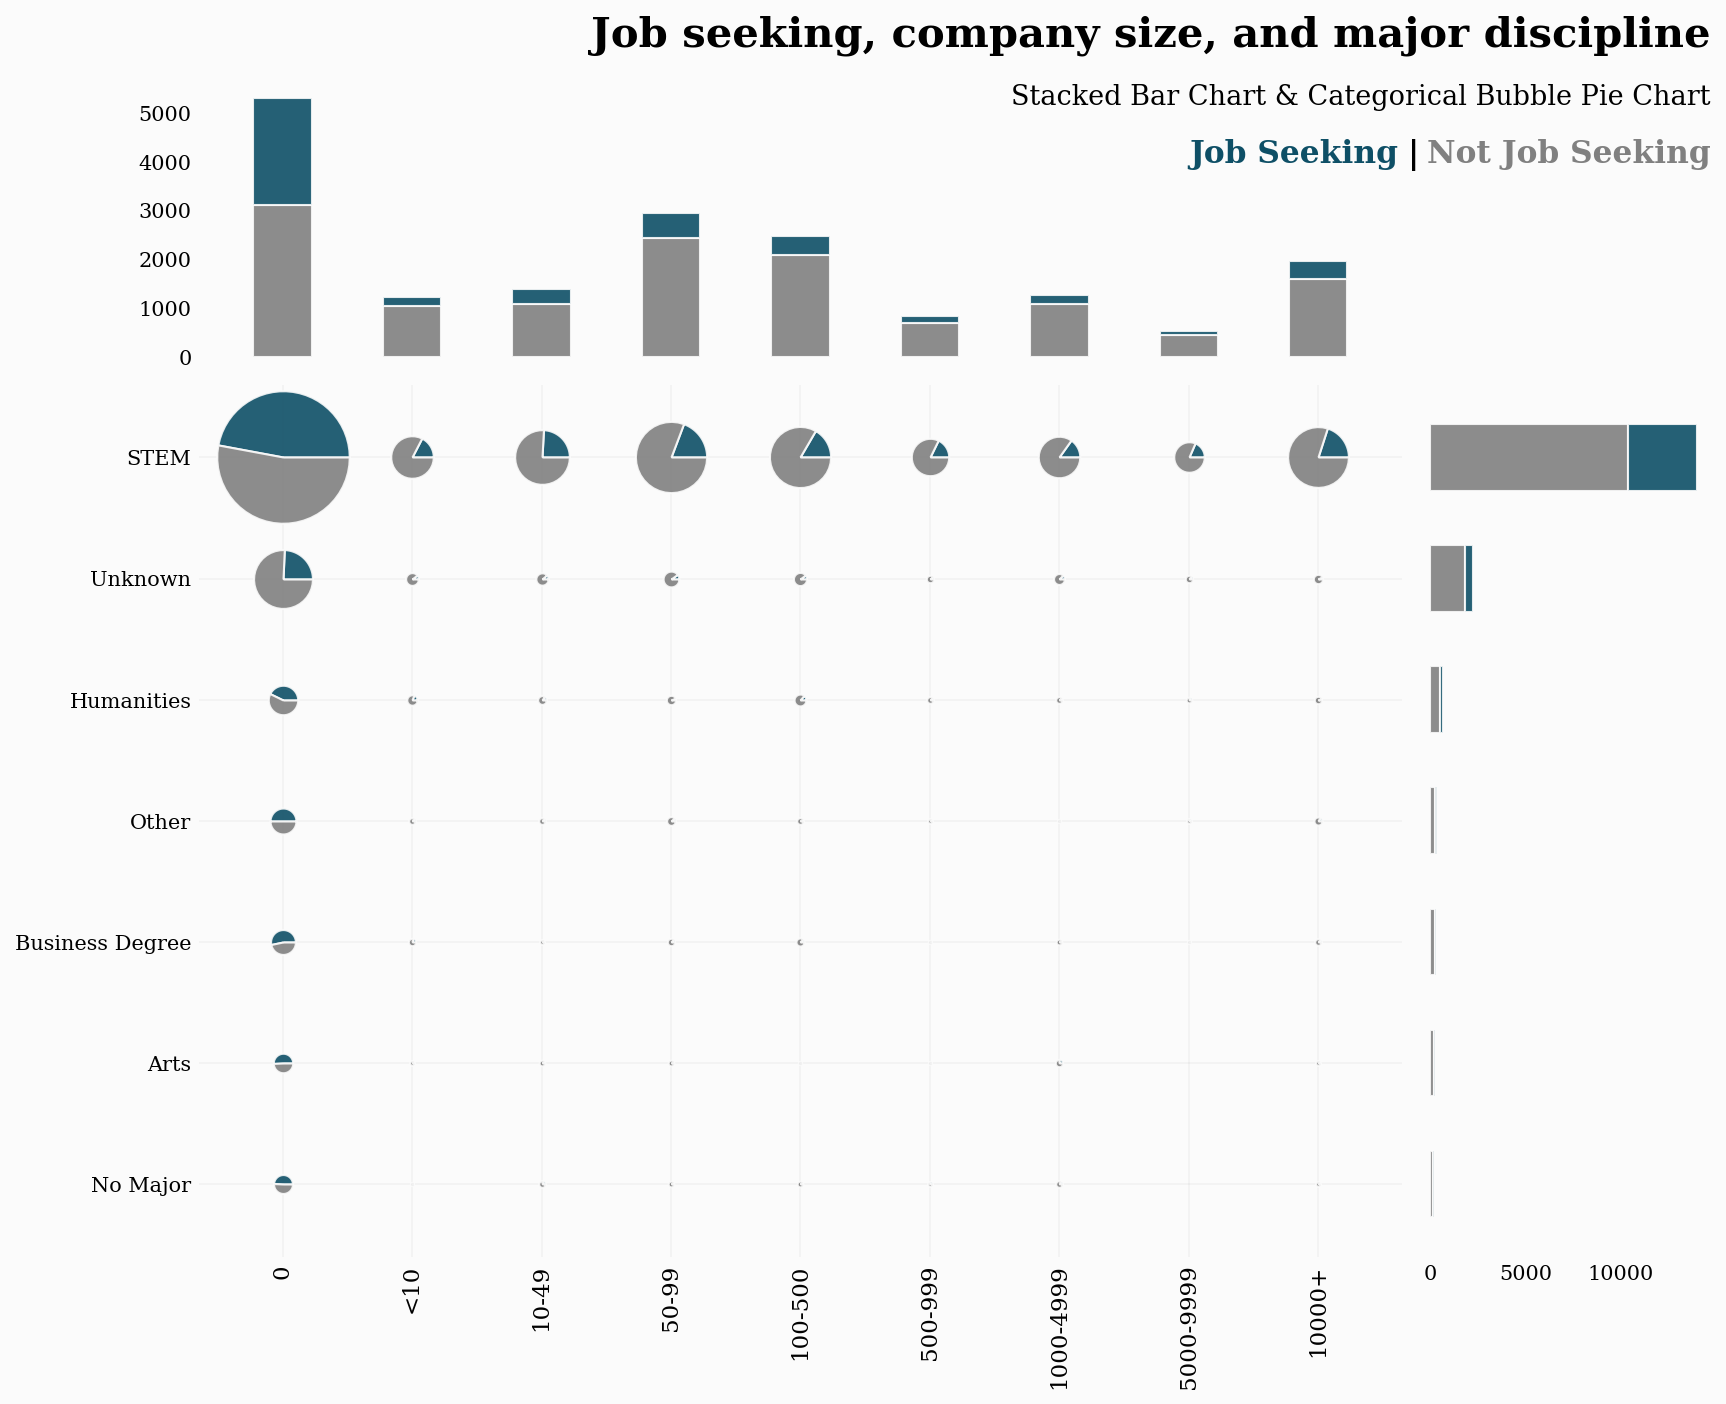

In [18]:
# Plot inspired by Subin An

fig = plt.figure(figsize=(13, 13), dpi=150)
gs = fig.add_gridspec(5, 5)
gs.update(wspace=0.1, hspace=0.1)
fig.patch.set_facecolor(background_color) 

# Pie 

ax_centre = fig.add_subplot(gs[1:4, 0:4]) 
for cl_idx in disc_order[::-1]:
    for age_idx in size_order:
        seek = data_job_seek[cl_idx][age_idx]
        no_seek = data_no_job_seek[cl_idx][age_idx]
        total = data_job_seek[cl_idx][age_idx]
        drawPieMarker([age_idx],[cl_idx], [seek/(seek+no_seek), no_seek/(seek+no_seek)] ,[total*2.5], ["#0e4f66", "gray"], ax=ax_centre)

ax_centre.grid(linewidth=0.1)        
ax_centre.set_facecolor(background_color)
ax_centre.set_xticklabels(size_order,fontfamily='serif', fontsize=11, rotation=90)

 # Top
ax_top = fig.add_subplot(gs[0, :4], sharex=ax_centre) 
c_size_non = data[data['target']==0]['company_size'].value_counts()[size_order]
ax_top.bar(c_size_non.index, c_size_non, width=0.45, alpha=0.9,ec=background_color, color='gray')

c_size = data[data['target']==1]['company_size'].value_counts()[size_order]
ax_top.bar(c_size.index, c_size, bottom=c_size_non , width=0.45, alpha=0.9, ec=background_color,color='#0e4f66')

plt.setp(ax_top.get_xticklabels(), visible=False)
ax_top.set_facecolor(background_color)

# Side 
ax_side = fig.add_subplot(gs[1:4, 4], sharey=ax_centre) 
disc_no = data[data['target']==0]['major_discipline'].value_counts()[disc_order]
ax_side.barh(disc_no.index[::-1], disc_no[::-1], height=0.55, alpha=0.9,ec=background_color, color='gray')

disc_yes = data[data['target']==1]['major_discipline'].value_counts()[disc_order]
ax_side.barh(disc_yes.index[::-1], disc_yes[::-1], left= disc_no[::-1],height=0.55, alpha=0.9, ec=background_color,color='#0e4f66')

plt.setp(ax_side.get_yticklabels(), visible=False)
ax_side.set_facecolor(background_color)

# Spines
for s in ['top', 'left', 'right', 'bottom']:
    ax_centre.spines[s].set_visible(False)
    ax_top.spines[s].set_visible(False)
    ax_side.spines[s].set_visible(False)
ax_centre.set_axisbelow(True)    

fig.text(0.9, 0.9, 'Job seeking, company size, and major discipline', fontweight='bold', fontfamily='serif', fontsize=20, ha='right') 
fig.text(0.9, 0.87, 'Stacked Bar Chart & Categorical Bubble Pie Chart', fontweight='light', fontfamily='serif', fontsize=13, ha='right')

fig.text(0.633,0.84,"Job Seeking", fontweight="bold", fontfamily='serif', fontsize=15, color='#0e4f66')
fig.text(0.745,0.84,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.755,0.84,"Not Job Seeking", fontweight="bold", fontfamily='serif', fontsize=15, color='gray')

ax_centre.tick_params(axis=u'both', which=u'both',length=0)
ax_top.tick_params(axis=u'both', which=u'both',length=0)
ax_side.tick_params(axis=u'both', which=u'both',length=0)

plt.tight_layout()
plt.show()

In [19]:

ed_order = ['Primary School','High School','Graduate','Masters','Phd']
enroll_order = ['No Enrollment','Part time course','Full time course']
disc_order = ['STEM','Unknown','Humanities','Other','Business Degree','Arts','No Major']
exp_yrs_order = ['<1','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','>20']
exp_yrs_order_2 = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
size_order = ['0','<10', '10-49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
job_order = ['Never', '1', '2', '3', '4', '>4']
exp_order =['No relevant experience','Has relevant experience']
gender_order = ['Male','Female','Other','Not provided']



In [20]:
job_change = aug_train.groupby(['education_level','last_new_job'])['experience'].sum().unstack().loc[ed_order,job_order]
jc_never = job_change['Never']


job_change_norm = pd.crosstab(aug_train['education_level'],aug_train['last_new_job'],normalize='columns').loc[ed_order,job_order,]
job_change_norm = round(job_change_norm*100,1).astype(int)




##
job_hunt_only = aug_train[aug_train['target']==1]
no_job_hunt_only = aug_train[aug_train['target']==0]


seekers_job_change_norm = pd.crosstab(job_hunt_only['education_level'],job_hunt_only['last_new_job'],normalize='columns').loc[ed_order,job_order,]
seekers_job_change_norm = round(seekers_job_change_norm*100,1).astype(int)
seekers_job_change_norm

non_seekers_job_change_norm = pd.crosstab(no_job_hunt_only['education_level'],no_job_hunt_only['last_new_job'],normalize='columns').loc[ed_order,job_order,]
non_seekers_job_change_norm = round(non_seekers_job_change_norm*100,1).astype(int)


# Prediction

The main purpose of the notebook is of course **visualization**, but I wanted to finish the process with the process of selecting a predictive model

I won't spend much time fine-tuning these models, but as long as we get a fairly decent result, above the Null Accuracy Score, I will be content. I will also visualize the results.


In [21]:
# Extra libs

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.svm import LinearSVC
from imblearn.over_sampling import BorderlineSMOTE
from numpy import where

In [22]:
list_of_columns = ['city', 'gender', 'relevent_experience', 'enrolled_university', 'education_level',
                   'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

aug_train_dummies_df = []

for col in list_of_columns:
    dummy_train_df = pd.get_dummies(aug_train[col])
    aug_train_dummies_df.append(dummy_train_df)


list_of_columns.append('enrollee_id')    
aug_train_dummies_df.insert(0, aug_train.drop(columns=list_of_columns))

aug_train = pd.concat(aug_train_dummies_df,axis=1)
aug_train = aug_train.drop('count', 1)

# Final look at our df
aug_train.head(3)

,city_development_index,training_hours,target,city_1,city_10,city_100,city_101,city_102,city_103,city_104,...,Other,Public Sector,Pvt Ltd,Unknown,1,2,3,4,>4,Never
0,0.920,36,1.0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0
1,0.776,47,0.0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,0.624,83,0.0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


# Modelling

I will try a series of algorithms on this problem. Let's see how we do...

In [23]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)


# Classification with a linear SVM
svc = LinearSVC(dual=False, random_state=123)
params_grid = {"C": [10 ** k for k in range(-3, 4)]}
clf = GridSearchCV(svc, params_grid)
clf.fit(X_train, y_train)
print(
    "Accuracy on the test set with raw data: {:.3f}".format(clf.score(X_test, y_test))
)

print(clf.best_params_)

Accuracy on the test set with raw data: 0.784
{'C': 0.1}


In [24]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

In [25]:
# Support Vector Machine (SVM / SVC)
pipeline = make_pipeline(StandardScaler(), SVC(kernel='sigmoid'))
pipeline.fit(X_train, y_train)
svc_prediction = pipeline.predict(X_test)
cm_svc = confusion_matrix(y_test, svc_prediction)
svc_df = pd.DataFrame(data=[accuracy_score(y_test, svc_prediction), recall_score(y_test, svc_prediction),
                   precision_score(y_test, svc_prediction), roc_auc_score(y_test, svc_prediction)], 
             columns=['SVC Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [26]:
# Basic Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
dtree_prediction = dtree.predict(X_test)
cm_dtree = confusion_matrix(y_test, dtree_prediction)
dtree_df = pd.DataFrame(data=[accuracy_score(y_test, dtree_prediction), recall_score(y_test, dtree_prediction),
                   precision_score(y_test, dtree_prediction), roc_auc_score(y_test, dtree_prediction)], 
             columns=['Decision Tree Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [27]:
# Random Forest
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)
rfc_prediction = rfc.predict(X_test)
cm_rfc = confusion_matrix(y_test, rfc_prediction)
rfc_df = pd.DataFrame(data=[accuracy_score(y_test, rfc_prediction), recall_score(y_test, rfc_prediction),
                   precision_score(y_test, rfc_prediction), roc_auc_score(y_test, rfc_prediction)], 
             columns=['Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [28]:
#param_grid = { 
#    'n_estimators': [ 500,800],
#    'max_features': ['auto', 'sqrt'],
#    'max_depth' : [7,8,9],
#    'criterion' :['gini', 'entropy']
#}

#CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
#CV_rfc.fit(X_train,y_train)
#CV_rfc.best_params_

In [29]:
# Tuned Random Forest
rfc1=RandomForestClassifier(random_state=0, n_estimators= 800, criterion = 'gini',max_features = 'auto',max_depth = 8)
rfc1.fit(X_train,y_train)
prediction_rf1= rfc1.predict(X_test)
cm_trfc = confusion_matrix(y_test, prediction_rf1)
trfc_df = pd.DataFrame(data=[accuracy_score(y_test, prediction_rf1), recall_score(y_test, prediction_rf1),
                   precision_score(y_test, prediction_rf1), roc_auc_score(y_test, prediction_rf1)], 
             columns=['Tuned Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [30]:
#Logistic Regression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)
log_prediction = logmodel.predict(X_test)
cm_log = confusion_matrix(y_test, log_prediction)
log_df = pd.DataFrame(data=[accuracy_score(y_test, log_prediction), recall_score(y_test, log_prediction),
                   precision_score(y_test, log_prediction), roc_auc_score(y_test, log_prediction)], 
             columns=['Logisitc Regression Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

In [31]:
X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

scaler = StandardScaler()
scaler.fit(aug_train.drop('target',axis=1))
scaled_features = scaler.transform(aug_train.drop('target',axis=1))

# re split
X_train, X_test, y_train, y_test = train_test_split(scaled_features,aug_train['target'],
                                                    test_size=0.30)

In [32]:
# K-Nearest Neighbours (KNN)
# searched already to find optimal neighbours, removed from notebook as took a long time
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train,y_train)
knn_prediction = knn.predict(X_test)
cm_knn = confusion_matrix(y_test, knn_prediction)
knn_df = pd.DataFrame(data=[accuracy_score(y_test, knn_prediction), recall_score(y_test, knn_prediction),
                   precision_score(y_test, knn_prediction), roc_auc_score(y_test, knn_prediction)], 
             columns=['KNN Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

# So far...

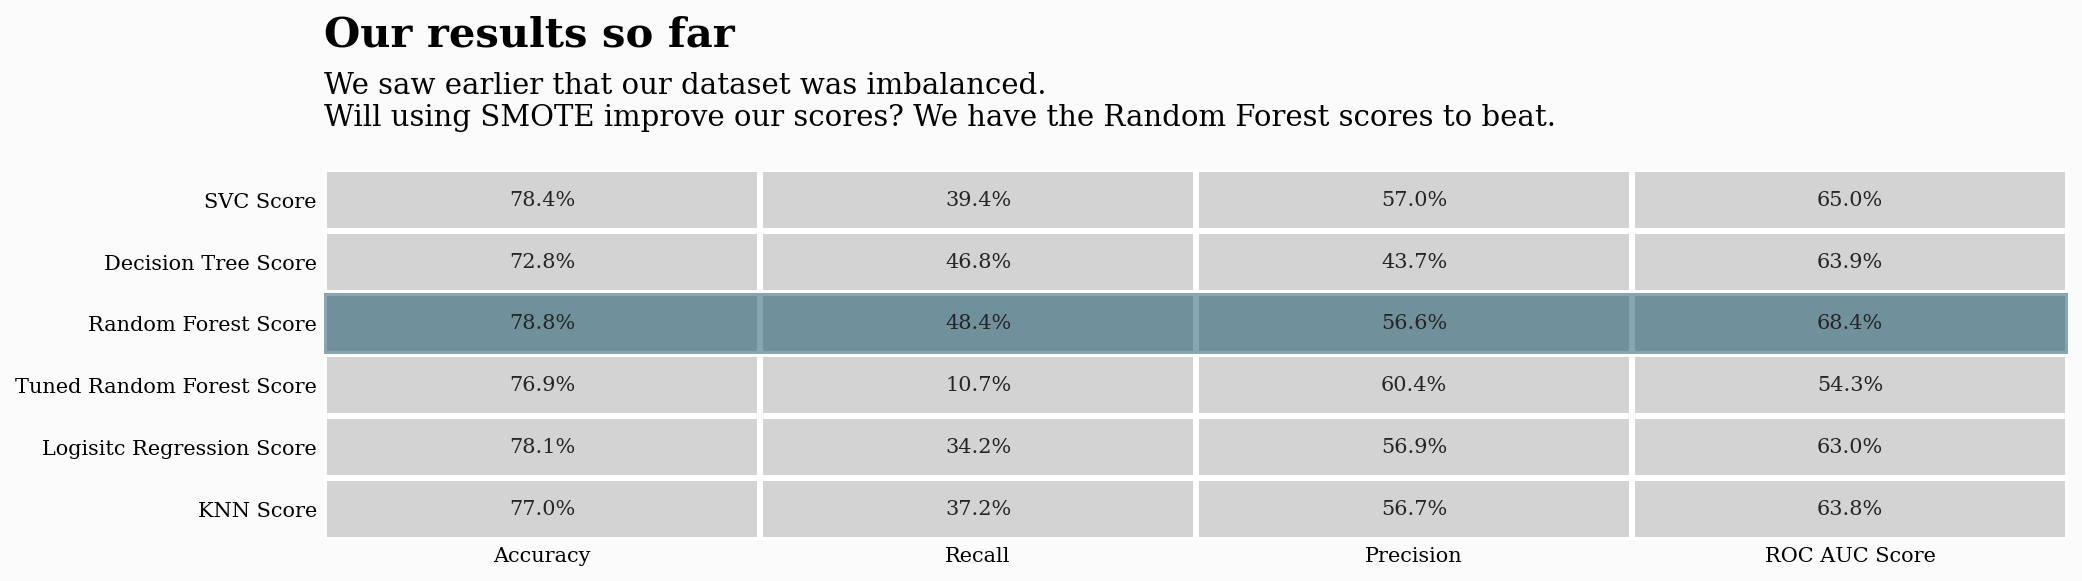

In [33]:
fig = plt.figure(figsize=(15,18), dpi=150)
gs = fig.add_gridspec(4, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)
# Change background color
background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) # figure background color
ax0.set_facecolor(background_color)

# Overall
df_models = round(pd.concat([svc_df,dtree_df,rfc_df,trfc_df,log_df,knn_df], axis=1),3)
sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax0)

ax0.tick_params(axis=u'both', which=u'both',length=0)
ax0.text(0,-2,'Our results so far',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(0,-0.7,'We saw earlier that our dataset was imbalanced.\nWill using SMOTE improve our scores? We have the Random Forest scores to beat.',fontfamily='serif',fontsize=14)

from matplotlib.patches import Rectangle

rect = ax0.add_patch(Rectangle((0, 2), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))



plt.show()

# Implementing SMOTE

SMOTE is a technique that helps deal with imbalanced data sets. 

A great introductory article can be found here:

https://www.geeksforgeeks.org/ml-handling-imbalanced-data-with-smote-and-near-miss-algorithm-in-python/

The common error I see people making is to use SMOTE and THEN split their data in to train & test sets. This is a big mistake as you will get some serious data leakage and end up predicting synthetic results that you have just created - it does not make sense. 

Instead, split your data first, and THEN use SMOTE on the training data only.

Let's see if it helps here...

In [34]:
# Our data is unbalanced, we can fix this with SMOTE

from imblearn.over_sampling import SMOTE

X = aug_train.dropna().drop(columns=['target']).values
y = aug_train.dropna()['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=80)

oversample = SMOTE()
X_train_resh, y_train_resh = oversample.fit_resample(X_train, y_train.ravel())

In [35]:
# Scale our data in pipeline

rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
svm_pipeline = Pipeline(steps = [('scale',StandardScaler()),('SVM',SVC(random_state=42))])
logreg_pipeline = Pipeline(steps = [('scale',StandardScaler()),('LR',LogisticRegression(random_state=42))])


In [36]:
#rf_cv = cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
#svm_cv = cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')
#logreg_cv = cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1')

In [37]:
print('Mean f1 scores:')
print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
# removed svm as took an incredibly long time to fit
#print('SVM mean :',cross_val_score(svm_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())
print('Logistic Regression mean :',cross_val_score(logreg_pipeline,X_train_resh,y_train_resh,cv=10,scoring='f1').mean())

Mean f1 scores:
Random Forest mean : 0.8287212223686996
Logistic Regression mean : 0.7853711954465132


On the training set at least, we are doing very well. 

I used f1 score as the metric as this is a weighted blend of accuracy & recall.

Let's try the test data...

In [38]:
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, precision_score, f1_score

rf_pipeline.fit(X_train_resh,y_train_resh)
#svm_pipeline.fit(X_train_resh,y_train_resh)
logreg_pipeline.fit(X_train_resh,y_train_resh)

rf_pred   =rf_pipeline.predict(X_test)
#svm_pred  = svm_pipeline.predict(X_test)
logreg_pred   = logreg_pipeline.predict(X_test)

rf_cm  = confusion_matrix(y_test,rf_pred )
#svm_cm = confusion_matrix(y_test,svm_pred)
logreg_cm  = confusion_matrix(y_test,logreg_pred )

rf_f1  = f1_score(y_test,rf_pred)
#svm_f1 = f1_score(y_test,svm_pred)
logreg_f1  = f1_score(y_test,logreg_pred)

In [39]:
print('Mean scores:')
print('RF F1 score:',rf_f1)
print('RF Accuracy:',accuracy_score(y_test,rf_pred))
print('LR F1 score :',logreg_f1)
print('LR Accuracy:',accuracy_score(y_test,logreg_pred))

Mean scores:
RF F1 score: 0.53556827473426
RF Accuracy: 0.7898242368177614
LR F1 score : 0.6068618193264086
LR Accuracy: 0.7689176688251619


The results are looking great. Let's see our models side-by-side so we can select the one that acheives our aims the best

In [40]:
smote_rf_df = pd.DataFrame(data=[accuracy_score(y_test, rf_pred), recall_score(y_test, rf_pred),
                   precision_score(y_test, rf_pred), roc_auc_score(y_test, rf_pred)], 
             columns=['SMOTE Random Forest Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])

smote_logreg_df = pd.DataFrame(data=[accuracy_score(y_test, logreg_pred), recall_score(y_test, logreg_pred),
                   precision_score(y_test, logreg_pred), roc_auc_score(y_test, logreg_pred)], 
             columns=['SMOTE Logistic Regression Score'],
             index=["Accuracy", "Recall", "Precision", "ROC AUC Score"])


smote_cm_log = confusion_matrix(y_test, logreg_pred)
smote_cm_rf = confusion_matrix(y_test, rf_pred)

# Viewing our results in an accesible way

We now now need to find a way to view our results which can be easily explained to business stakeholders. 

A simple annotated heatmap works well for this!

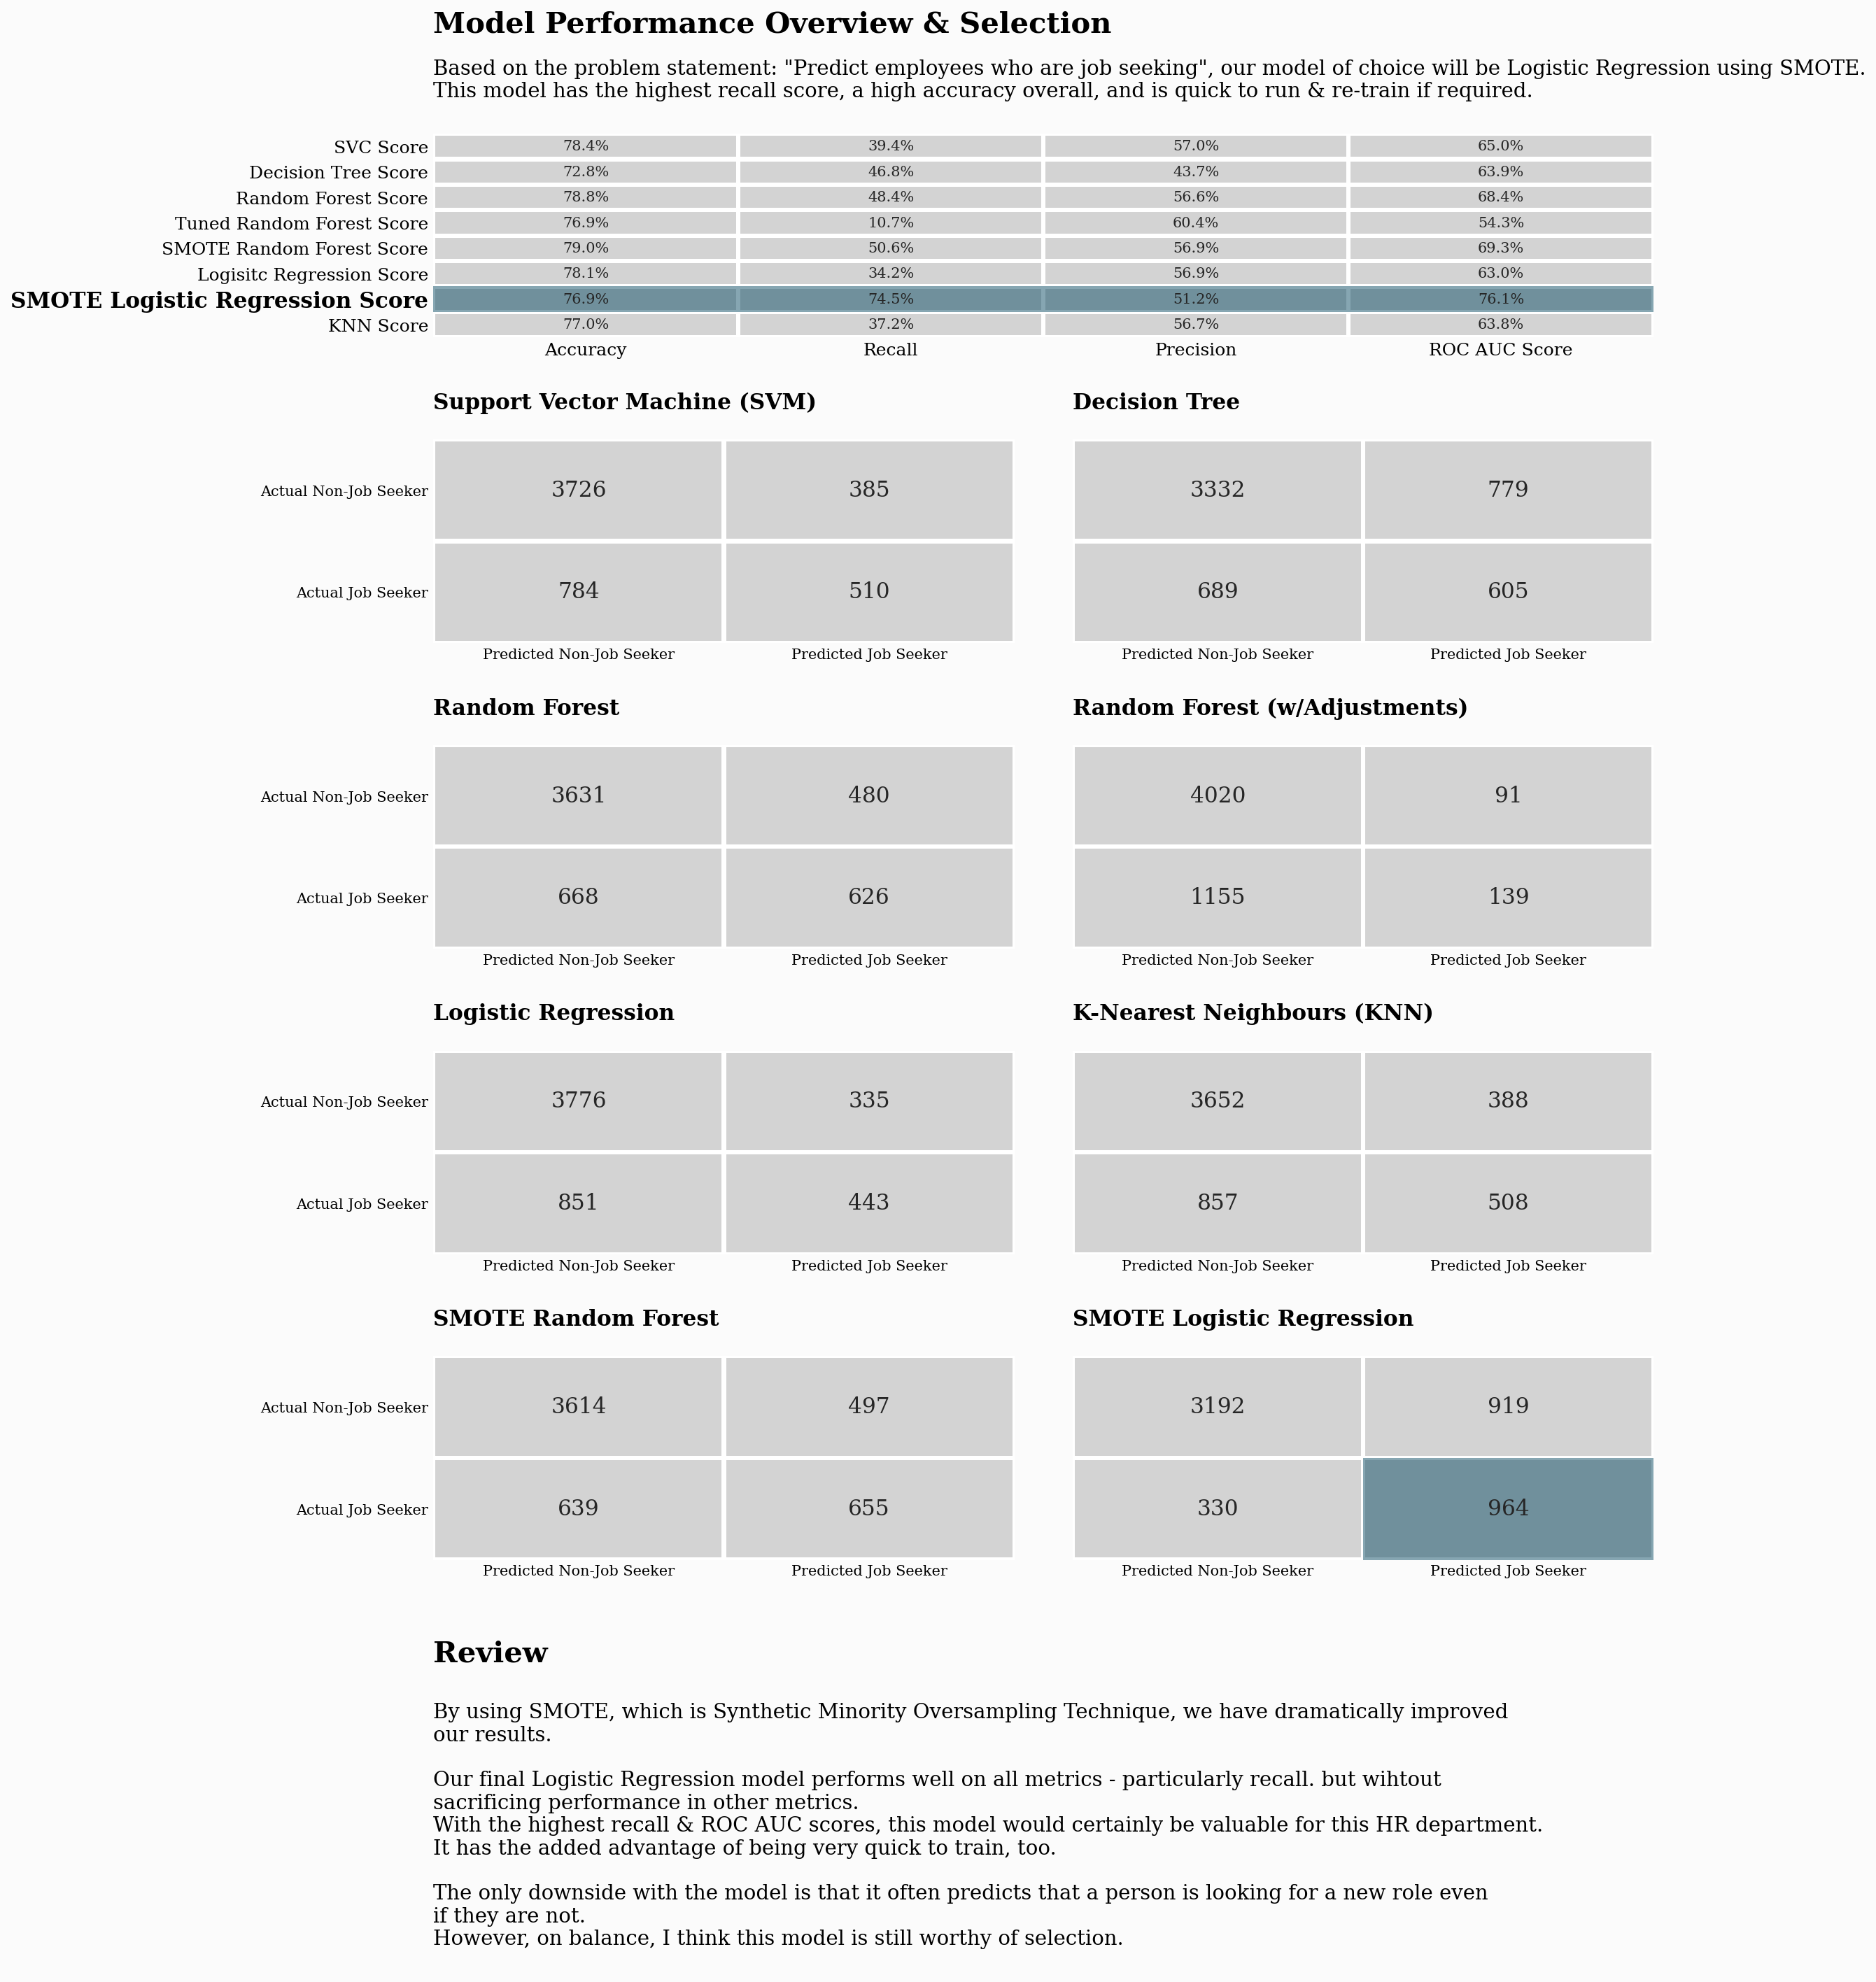

In [41]:
# Plotting our results

colors = ["lightgray","lightgray"]
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)


fig = plt.figure(figsize=(15,18), dpi=150) # create figure
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3,1])
ax7 = fig.add_subplot(gs[4,0])
ax8 = fig.add_subplot(gs[4,1])

# Overall
df_models = round(pd.concat([svc_df,dtree_df,rfc_df,trfc_df,smote_rf_df,log_df,smote_logreg_df,knn_df], axis=1),3)
sns.heatmap(df_models.T, cmap=colormap,annot=True,fmt=".1%", linewidths=2.5,cbar=False,ax=ax0)


ax0.set_yticklabels(ax0.get_yticklabels(), fontfamily='serif', rotation = 0, fontsize=12)
ax0.set_xticklabels(ax0.get_xticklabels(), fontfamily='serif', rotation=0, fontsize=12)

ax0.text(0,-4,'Model Performance Overview & Selection',fontfamily='serif',fontsize=20,fontweight='bold')
ax0.text(0,-0.55,
         '''
Based on the problem statement: "Predict employees who are job seeking", our model of choice will be Logistic Regression using SMOTE.
This model has the highest recall score, a high accuracy overall, and is quick to run & re-train if required.
'''
         ,fontfamily='serif',fontsize=14)



for lab, annot in zip(ax0.get_yticklabels(), ax0.texts):
    text =  lab.get_text()
    if text == 'SMOTE Logistic Regression Score': 
        # set the properties of the ticklabel
        lab.set_weight('bold')
        lab.set_size(15)
        lab.set_color('black')
        



from matplotlib.patches import Rectangle

rect = ax0.add_patch(Rectangle((0, 6), 5, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))



# svc
sns.heatmap(cm_svc, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax1,annot_kws={"fontsize":15})

# dtree
sns.heatmap(cm_dtree, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax2,annot_kws={"fontsize":15})

# rf
sns.heatmap(cm_rfc, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax3,annot_kws={"fontsize":15})

# tuned rf
sns.heatmap(cm_trfc, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax4,annot_kws={"fontsize":15})

# log
sns.heatmap(cm_log, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax5,annot_kws={"fontsize":15})

# knn
sns.heatmap(cm_knn, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax6,annot_kws={"fontsize":15})

# smote rf
sns.heatmap(smote_cm_rf, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax7,annot_kws={"fontsize":15})

# smote log reg
sns.heatmap(smote_cm_log, linewidths=2.5,yticklabels=False,xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax8,annot_kws={"fontsize":15})



background_color = "#fbfbfb"
fig.patch.set_facecolor(background_color) 

ax0.set_xlabel("")
ax0.set_ylabel("")


ax1.text(0, -0.3, 'Support Vector Machine (SVM)',fontsize=15, fontweight='bold', fontfamily='serif')
ax2.text(0, -0.3, 'Decision Tree', fontsize=15, fontweight='bold', fontfamily='serif')
ax3.text(0, -0.3, 'Random Forest',fontsize=15, fontweight='bold', fontfamily='serif')
ax4.text(0, -0.3, 'Random Forest (w/Adjustments)', fontsize=15, fontweight='bold', fontfamily='serif')
ax5.text(0, -0.3, 'Logistic Regression',fontsize=15, fontweight='bold', fontfamily='serif')
ax6.text(0, -0.3, 'K-Nearest Neighbours (KNN)', fontsize=15, fontweight='bold', fontfamily='serif')
ax7.text(0, -0.3, 'SMOTE Random Forest',fontsize=15, fontweight='bold', fontfamily='serif')
ax8.text(0, -0.3, 'SMOTE Logistic Regression', fontsize=15, fontweight='bold', fontfamily='serif')


ax7.text(0, 3, 'Review',fontsize=20, fontweight='bold', fontfamily='serif')
ax7.text(0, 6, 
'''
By using SMOTE, which is Synthetic Minority Oversampling Technique, we have dramatically improved
our results.

Our final Logistic Regression model performs well on all metrics - particularly recall. but wihtout
sacrificing performance in other metrics.
With the highest recall & ROC AUC scores, this model would certainly be valuable for this HR department.
It has the added advantage of being very quick to train, too.

The only downside with the model is that it often predicts that a person is looking for a new role even
if they are not. 
However, on balance, I think this model is still worthy of selection. 
''',fontsize=14, fontfamily='serif')


from matplotlib.patches import Rectangle


ax8.add_patch(Rectangle((1, 1), 1, 1, fill=True,color='#0e4f66', edgecolor='white', lw=0,alpha=0.5))

colors = ['gray','#0e4f66','#002d1d']
colormap = matplotlib.colors.LinearSegmentedColormap.from_list("", colors)

for i in range(0,9):
    locals()["ax"+str(i)].set_facecolor(background_color) 
    
for i in range(0,9):
    locals()["ax"+str(i)].tick_params(axis=u'both', which=u'both',length=0)


for s in ["top","right","left"]:
    for i in range(0,9):
        locals()["ax"+str(i)].spines[s].set_visible(False)

plt.show()

# Something else... Borderline SMOTE

There are many oversampling techniques that one could employ. 

A variation of the technique used above is **Borderline SMOTE**.

Borderline SMOTE involves selecting those instances of the minority class that are misclassified.

We can then oversample just those difficult instances, providing more resolution only where it may be required

A great article cab be found here:

https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/



In [42]:
oversample = BorderlineSMOTE()
X_train_resh_bord, y_train_resh_bord = oversample.fit_resample(X_train, y_train.ravel())

In [43]:
rf_pipeline.fit(X_train_resh_bord,y_train_resh_bord)
logreg_pipeline.fit(X_train_resh_bord,y_train_resh_bord)

rf_pred   =rf_pipeline.predict(X_test)
logreg_pred   = logreg_pipeline.predict(X_test)

rf_cm  = confusion_matrix(y_test,rf_pred )
logreg_cm  = confusion_matrix(y_test,logreg_pred )

rf_f1  = f1_score(y_test,rf_pred)
logreg_f1  = f1_score(y_test,logreg_pred)

print('Mean scores:')
print('RF F1 score:',rf_f1)
print('RF Accuracy:',accuracy_score(y_test,rf_pred))
print('LR F1 score :',logreg_f1)
print('LR Accuracy:',accuracy_score(y_test,logreg_pred))

Mean scores:
RF F1 score: 0.5323505323505323
RF Accuracy: 0.7887141535615171
LR F1 score : 0.6076826196473551
LR Accuracy: 0.769472710453284


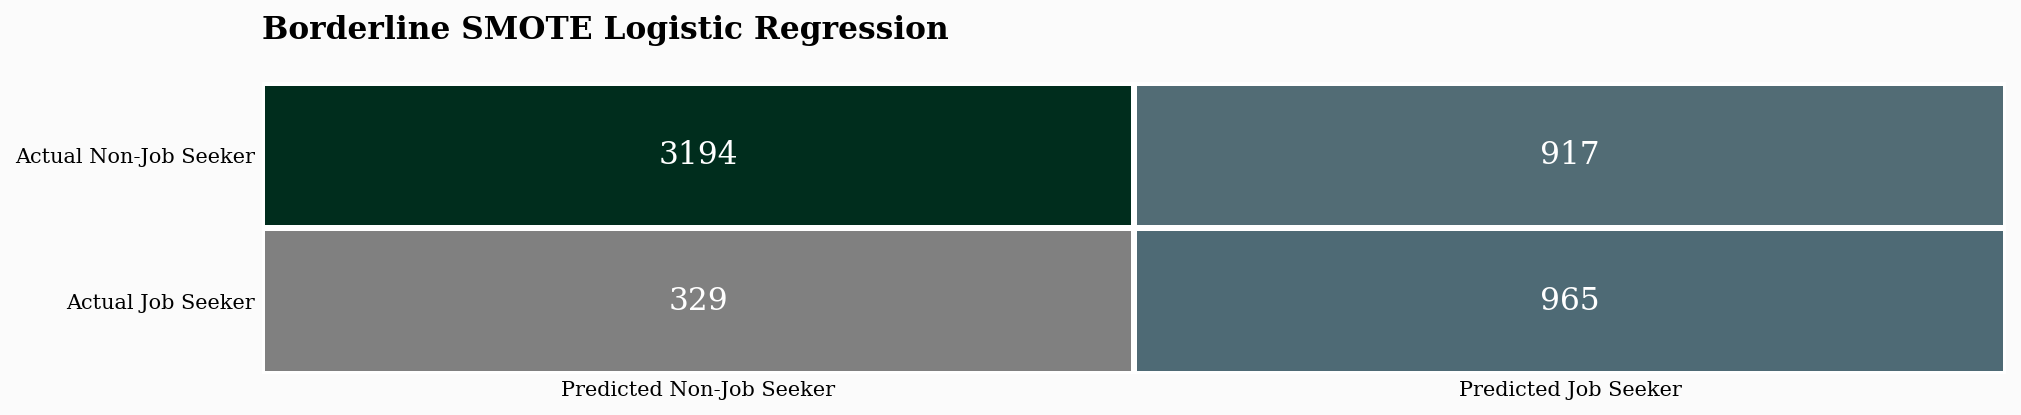

In [44]:
fig = plt.figure(figsize=(15,18), dpi=150) 
fig.patch.set_facecolor(background_color) 
gs = fig.add_gridspec(5, 2)
gs.update(wspace=0.1, hspace=0.5)
ax0 = fig.add_subplot(gs[0, :])

# borderline smote log reg
sns.heatmap(logreg_cm, linewidths=2.5,yticklabels=['Actual Non-Job Seeker','Actual Job Seeker'],xticklabels=['Predicted Non-Job Seeker','Predicted Job Seeker'], cmap=colormap, cbar=None,annot=True,fmt='d',ax=ax0,annot_kws={"fontsize":15})

ax0.set_facecolor(background_color) 
ax0.tick_params(axis=u'both', which=u'both',length=0)


for s in ["top","right","left"]:
    ax0.spines[s].set_visible(False)
    
ax0.text(0, -0.3, 'Borderline SMOTE Logistic Regression',fontsize=15, fontweight='bold', fontfamily='serif')
    
plt.show()

We see above, that by using Borderline SMOTE **we have managed to improve recall**, capturing 964 job seekers as opposed to 960 with regular SMOTE.

# Conclusion

**So there we have it**

We have explored and visualized our data in interesting ways - designed to enageg the reader.

Along the way we dealt with null values & performed feauture engineering so get a more complete view of our data.

Finally, we performed several machine learning algorithms to try to predict whether or not someone would be a job seeker or not.
We looked at:
- SVM
- Decision Trees
- Random Forests
- Logisitic Regression
- KNN

Next, we looked at addressing the imbalance in our data. Could this improve our models?

I used SMOTE, and re-trained Logistics Regression & Random Forest models. The Logistic Regression model performed great and I decided that would be the model I would select.

We did not do much model tuning, so the final score could almost certainly be improved upon - but we still achieved good results!


Easy to implement next steps could be:

- Hyperparameter tuning
- Threshold manipulation 

Next, I also presented my findings in a way such that we could **explain our results** to business stakeholders.

# Thank you for reading

If you found value in this notebook, please **upvote** 

Have a great day!


# More of my work



**Gold price prediction using Prophet**

https://www.kaggle.com/joshuaswords/eda-gold-price-prediction-prophet


**Computer Vision with FastAI - Pneumonia prediction**

https://www.kaggle.com/joshuaswords/computer-vision-pneumonia-prediction-fastai


**Stroke Prediction with SMOTE and LIME explainer**

https://www.kaggle.com/joshuaswords/predicting-a-stroke-95-acc-with-lime-explainer


**2021 World Happiness Index EDA**

https://www.kaggle.com/joshuaswords/awesome-eda-2021-happiness-population

The pie chart visual was inspired by Subin An, check out his page if you get the chance

https://www.kaggle.com/subinium
